# <span style='font-family:"Times New Roman"'> <span styel=''>**PAN CANCER GENOME INSTABILITY PLOT**
*Emile Cohen*
    
 *May 2020*

**Goal:** In this notebook, we want to summarize Genome instability differences in subgroups across all cancers. For that we will plot the fraction of genome altered for each subgroup for eahc cancer.

---

In [209]:
%run -i '../../../utils/setup_environment.ipy'

import warnings
warnings.filterwarnings('ignore')
from cancer_utils import *
from scipy.stats import fisher_exact, ranksums, chi2, norm
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.gridspec as gridspec

data_path = '../../../data/'

Setup environment... done!


<span style="color:green">✅ Working on **mskimpact_env** conda environment.</span>

# Non-WGD Cohort

In [202]:
cohort_type = 'no_wgd'
metrics = 'frac_genome_altered'
ylim = 1

In [218]:
master = non_wgd_load_and_cut(data_path + 'impact-facets-tp53/processed/no_wgd/master_no_wgd.pkl')

# cancer list 
cancer_count = get_groupby(master[~master['tp53_group'].isna()], 'Cancer_Type', 'count').sort_values(by='count', ascending = False)
cancer_list = list(cancer_count[cancer_count['count']>=70].index.values)

In [223]:
get_groupby(master, 'tp53_res_group', 'count')

count
tp53_res_group       
no_tp53_res      4505
tp53_res         3016
uncertain         119

## 'Paper' version

### Ordering the cancer types
We order cancer types so that the >=1_cnLOH medians are ascending

In [210]:
# Filter and order the samples in order to plot with decreasing medians on the cnloh subgroup
master_list = master[master['Cancer_Type'].isin(cancer_list)]
master_list_cnloh = master_list[master_list['tp53_group'] == '>=1_cnLOH']
cancer_order = master_list_cnloh.groupby('Cancer_Type')['frac_genome_altered']\
                                .apply(np.median)\
                                .sort_values(ascending=True)\
                                .index\
                                .tolist()
samples_list_ordered=[]
for cancer in cancer_order:
    samples_list_ordered = samples_list_ordered + master_list[master_list['Cancer_Type'] == cancer].index.tolist()
#samples_list_ordered

master_ordered = master_list.reindex(samples_list_ordered)

### Subgroups

CPU times: user 1min 22s, sys: 7.58 s, total: 1min 29s
Wall time: 32.4 s


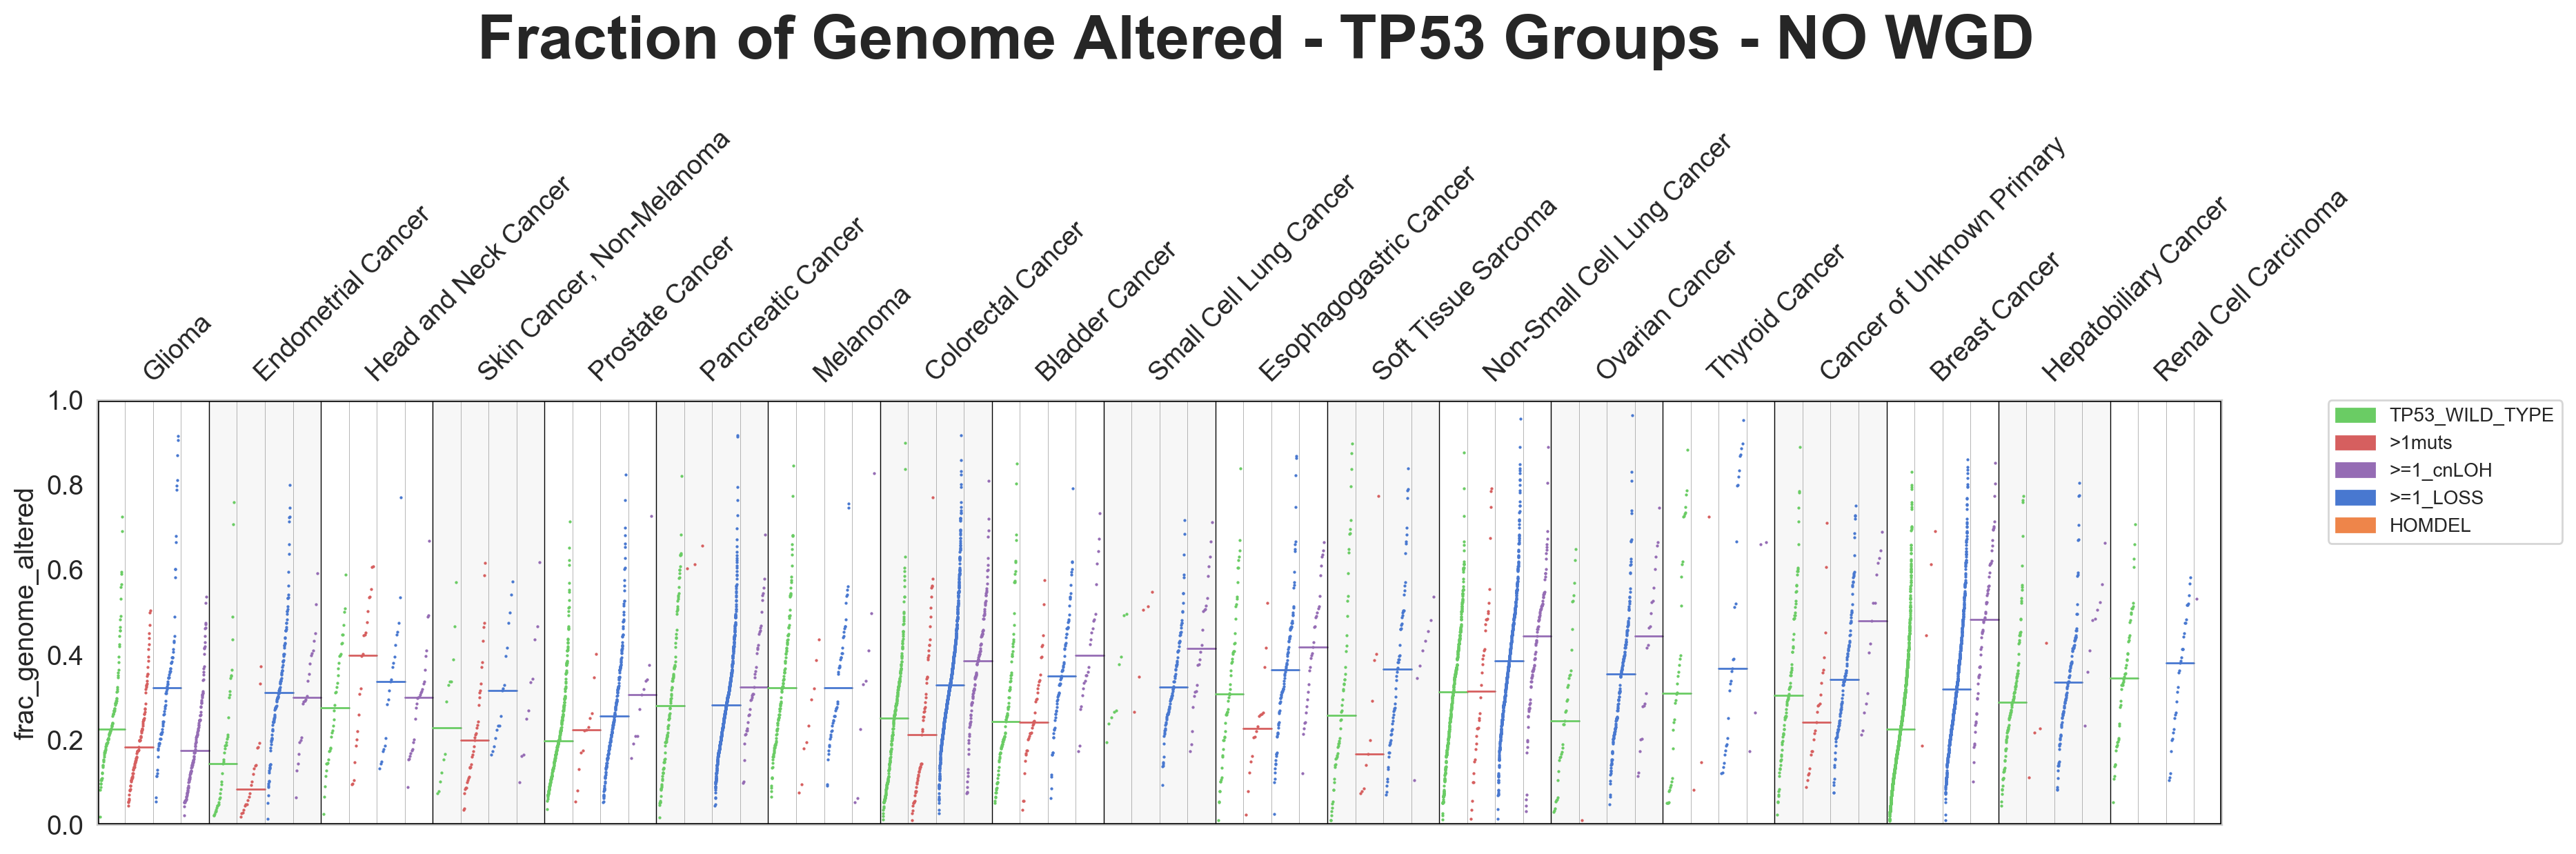

In [211]:
%%time
# Let's begin with. one subgroup : >=1_cnLOH
sns.set_style("whitegrid", {'grid.color': '1.'})

fig = plt.figure(figsize=(20,7))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)

import itertools
col = itertools.cycle(["#FFFFFF","#FFFFFF","#FFFFFF","#FFFFFF","#F7F7F7","#F7F7F7","#F7F7F7","#F7F7F7"])
labels = []

#order = medians.sort_values(ascending=False)
for i, (group, df) in enumerate(master_ordered.groupby(by="Cancer_Type", sort=False)):
    i = 4*i
    labels.append(group)
    
    # Mono Allelic Subgroup in GREEN
    df_mono = df[df['tp53_group'].isin(['1_WILD_TYPE','0_HETLOSS'])]
    totalsamples_mono = df_mono.shape[0]
    df_mono = df_mono.sort_values(metrics)
    plt.axvspan(xmin=i-0.5,xmax=i+0.5,color=next(col),zorder=1)
    if totalsamples_mono>0:
        for j,(_,row) in enumerate(df_mono.iterrows()):
            plt.scatter(i-0.4+(j/totalsamples_mono)*0.8,row[metrics],color=palette['1_WILD_TYPE'],s=0.3,zorder=2)
        
        if df_mono.shape[0]>10:
            median_mono  = df_mono[metrics].median()
            plt.plot([i-0.5,i+0.5],[median_mono,median_mono],color=palette['1_WILD_TYPE'], linewidth=1)
    
    plt.plot([i+0.5,i+0.5],[0,ylim],color='#7F7F7F', linewidth=0.2)
    
    # >1muts Subgroup in RED
    k = i+1
    df_muts = df[df['tp53_group'] == '>1muts']
    totalsamples_muts = df_muts.shape[0]
    df_muts = df_muts.sort_values(metrics)
    plt.axvspan(xmin=k-0.5,xmax=k+0.5,color=next(col),zorder=1)
    if totalsamples_muts>0:
        for j,(_,row) in enumerate(df_muts.iterrows()):
            plt.scatter(k-0.4+(j/totalsamples_muts)*0.8,row[metrics],color=palette['>1muts'],s=0.3,zorder=2)
    
        if df_muts.shape[0]>10:
            median_muts  = df_muts[metrics].median()
            plt.plot([k-0.5,k+0.5],[median_muts,median_muts],color=palette['>1muts'], linewidth=1)
    
    plt.plot([k+0.5,k+0.5],[0,ylim],color='#7F7F7F', linewidth=0.2)
    
    # LOSS Subgroup in BLUE
    h = i+2
    df_loss = df[df['tp53_group']=='>=1_LOSS']
    totalsamples_loss = df_loss.shape[0]
    df_loss = df_loss.sort_values(metrics)
    plt.axvspan(xmin=h-0.5,xmax=h+0.5,color=next(col),zorder=1)
    if totalsamples_loss>0:
        for j,(_,row) in enumerate(df_loss.iterrows()):
            plt.scatter(h-0.4+(j/totalsamples_loss)*0.8,row[metrics],color=palette['>=1_LOSS'],s=0.3,zorder=2)
        
        if df_loss.shape[0]>10:
            median_loss  = df_loss[metrics].median()
            plt.plot([h-0.5,h+0.5],[median_loss,median_loss],color=palette['>=1_LOSS'], linewidth=1)
    
    plt.plot([h+0.5,h+0.5],[0,ylim],color='#7F7F7F', linewidth=0.2)
    
    # CNLOH Subgroup in PURPLE
    g = i+3
    df_cnloh = df[df['tp53_group'] == '>=1_cnLOH']
    totalsamples_cnloh = df_cnloh.shape[0]
    df_cnloh = df_cnloh.sort_values(metrics)
    plt.axvspan(xmin=g-0.5,xmax=g+0.5,color=next(col),zorder=1)
    if totalsamples_cnloh>0:
        for j,(_,row) in enumerate(df_cnloh.iterrows()):
            plt.scatter(g-0.4+(j/totalsamples_cnloh)*0.8,row[metrics],color=palette['>=1_cnLOH'],s=0.3,zorder=2)

        if df_cnloh.shape[0]>10:    
            median_cnloh  = df_cnloh[metrics].median()
            plt.plot([g-0.5,g+0.5],[median_cnloh,median_cnloh],color=palette['>=1_cnLOH'], linewidth=1)
    
    plt.plot([g+0.5,g+0.5],[0,ylim],color='black', linewidth=0.5) ##7F7F7F
  
num_dis = len(master[master['Cancer_Type'].isin(cancer_list)]["Cancer_Type"].unique())*4
real_labels = ['']*num_dis
for i,label in enumerate(labels):
    real_labels[4*i + 1] = label
    

ax.xaxis.tick_top()
plt.xticks([k for k in range(num_dis)], real_labels, rotation=45, ha="left", fontsize=14)
ax.xaxis.set_ticks_position('none')
plt.xlim(-0.5,num_dis-0.5)
plt.ylim(0,ylim)
# Grid
'''plt.plot([-0.5,num_dis+0.5],[0.2,0.2],color="black", linewidth=0.5, linestyle=':')
plt.plot([-0.5,num_dis+0.5],[0.4,0.4],color="black", linewidth=0.5, linestyle=':')
plt.plot([-0.5,num_dis+0.5],[0.6,0.6],color="black", linewidth=0.5, linestyle=':')
plt.plot([-0.5,num_dis+0.5],[0.8,0.8],color="black", linewidth=0.5, linestyle=':')
'''

# Border lines
plt.plot([-0.5,num_dis-0.5],[0,0],color="black", linewidth=2, linestyle='-')
plt.plot([-0.5,num_dis-0.5],[ylim,ylim],color="black", linewidth=2, linestyle='-')
plt.plot([-0.5,-0.5],[0,ylim],color="black", linewidth=2, linestyle='-')
plt.plot([num_dis-0.5,num_dis-0.5],[0,ylim],color="black", linewidth=2, linestyle='-')

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
plt.xlabel("")
plt.ylabel(metrics, fontsize=14)

palette_ = dict(zip(['TP53_WILD_TYPE', '>1muts', '>=1_cnLOH', '>=1_LOSS','HOMDEL'], [mc[2],mc[3],mc[4],mc[0],mc[1]]))
# Create legend handles manually
handles = [matplotlib.patches.Patch(color=palette_[x], label=x) for x in palette_.keys()]
# Create legend
ax.legend(handles=handles,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)



fig.subplots_adjust(left=0.08, bottom=0.14, right=0.85, top=0.58, wspace=2, hspace=1)
fig.suptitle('Fraction of Genome Altered - TP53 Groups' + ' - NO WGD', fontsize=32,fontweight='bold')
fig.savefig('./gi_pancancer/no_wgd/pancancer_frac_no_wgd.pdf' , format='pdf')


### TP53 Residual Groups

CPU times: user 1min 23s, sys: 7.75 s, total: 1min 30s
Wall time: 33.1 s


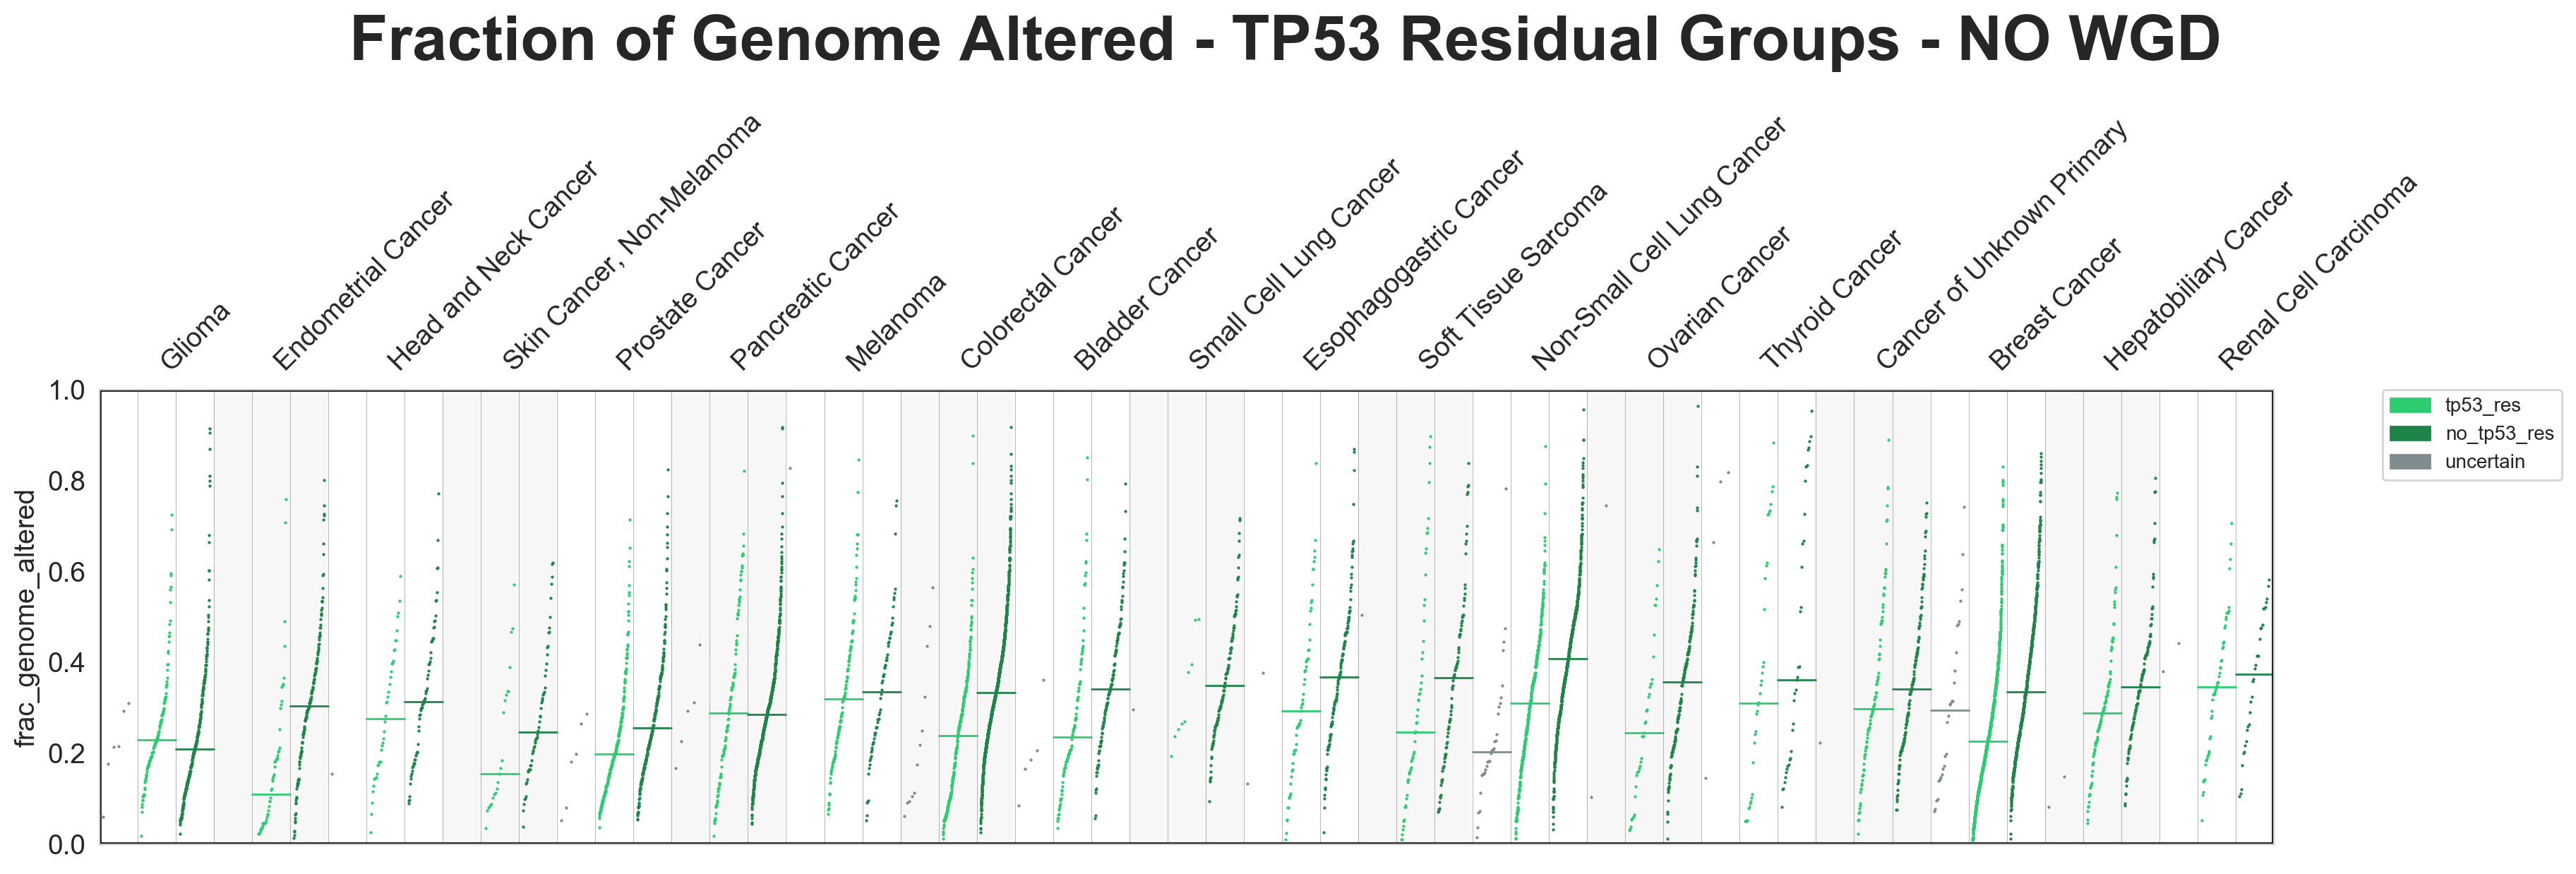

In [215]:
%%time
# Let's begin with. one subgroup : >=1_cnLOH
sns.set_style("whitegrid", {'grid.color': '1.'})

fig = plt.figure(figsize=(20,7))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)

import itertools
col = itertools.cycle(["#FFFFFF","#FFFFFF","#FFFFFF","#F7F7F7","#F7F7F7","#F7F7F7"])
labels = []

#order = medians.sort_values(ascending=False)
for i, (group, df) in enumerate(master_ordered.groupby(by="Cancer_Type", sort=False)):
    i = 3*i
    labels.append(group)
    
    # Uncertain Subgroup in Grey
    df_mono = df[df['tp53_res_group'] == 'uncertain']
    totalsamples_mono = df_mono.shape[0]
    df_mono = df_mono.sort_values(metrics)
    plt.axvspan(xmin=i-0.5,xmax=i+0.5,color=next(col),zorder=1)
    if totalsamples_mono>0:
        for j,(_,row) in enumerate(df_mono.iterrows()):
            plt.scatter(i-0.4+(j/totalsamples_mono)*0.8,row[metrics],color=palette_res['uncertain'],s=0.3,zorder=2)
        
        if df_mono.shape[0]>20:
            median_mono  = df_mono[metrics].median()
            plt.plot([i-0.5,i+0.5],[median_mono,median_mono],color=palette_res['uncertain'], linewidth=1)
    
    plt.plot([i+0.5,i+0.5],[0,1],color='#7F7F7F', linewidth=0.2)
    
    # tp53_res Subgroup in green
    k = i+1
    df_muts = df[df['tp53_res_group'] == 'tp53_res']
    totalsamples_muts = df_muts.shape[0]
    df_muts = df_muts.sort_values(metrics)
    plt.axvspan(xmin=k-0.5,xmax=k+0.5,color=next(col),zorder=1)
    if totalsamples_muts>0:
        for j,(_,row) in enumerate(df_muts.iterrows()):
            plt.scatter(k-0.4+(j/totalsamples_muts)*0.8,row[metrics],color=palette_res['tp53_res'],s=0.3,zorder=2)
    
        if df_muts.shape[0]>20:
            median_muts  = df_muts[metrics].median()
            plt.plot([k-0.5,k+0.5],[median_muts,median_muts],color=palette_res['tp53_res'], linewidth=1)
    
    plt.plot([k+0.5,k+0.5],[0,1],color='#7F7F7F', linewidth=0.2)
    
    # no_tp53_res in dark green
    h = i+2
    df_loss = df[df['tp53_res_group']=='no_tp53_res']
    totalsamples_loss = df_loss.shape[0]
    df_loss = df_loss.sort_values(metrics)
    plt.axvspan(xmin=h-0.5,xmax=h+0.5,color=next(col),zorder=1)
    if totalsamples_loss>0:
        for j,(_,row) in enumerate(df_loss.iterrows()):
            plt.scatter(h-0.4+(j/totalsamples_loss)*0.8,row[metrics],color=palette_res['no_tp53_res'],s=0.3,zorder=2)
        
        if df_loss.shape[0]>20:
            median_loss  = df_loss[metrics].median()
            plt.plot([h-0.5,h+0.5],[median_loss,median_loss],color=palette_res['no_tp53_res'], linewidth=1)
    
    plt.plot([h+0.5,h+0.5],[0,1],color='#7F7F7F', linewidth=0.2)

  
num_dis = len(master[master['Cancer_Type'].isin(cancer_list)]["Cancer_Type"].unique())*3
real_labels = ['']*num_dis
for i,label in enumerate(labels):
    real_labels[3*i + 1] = label
    

ax.xaxis.tick_top()
plt.xticks([k for k in range(num_dis)], real_labels, rotation=45, ha="left", fontsize=14)
ax.xaxis.set_ticks_position('none')
plt.xlim(-0.5,num_dis-0.5)
plt.ylim(0,ylim)

# Border lines
plt.plot([-0.5,num_dis-0.5],[0,0],color="black", linewidth=2, linestyle='-')
plt.plot([-0.5,num_dis-0.5],[1,1],color="black", linewidth=2, linestyle='-')
plt.plot([-0.5,-0.5],[0,1],color="black", linewidth=2, linestyle='-')
plt.plot([num_dis-0.5,num_dis-0.5],[0,1],color="black", linewidth=2, linestyle='-')

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
plt.xlabel("")
plt.ylabel(metrics, fontsize=14)

palette_ = dict(zip(res_group_list, res_palette_list))
# Create legend handles manually
handles = [matplotlib.patches.Patch(color=palette_[x], label=x) for x in palette_.keys()]
# Create legend
ax.legend(handles=handles,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

fig.subplots_adjust(left=0.08, bottom=0.14, right=0.85, top=0.6, wspace=2, hspace=1)
fig.suptitle( 'Fraction of Genome Altered - TP53 Residual Groups' + ' - NO WGD', fontsize=32,fontweight='bold')
fig.savefig('./gi_pancancer/no_wgd/pancancer_frac_res_no_wgd.pdf' , format='pdf')


In [23]:
arm_level = pd.read_csv(data_path + 'impact-facets-tp53/raw/default_qc_pass.arm_level.txt', sep='\t')

## Version with all subgroups

CPU times: user 1min 36s, sys: 11.4 s, total: 1min 47s
Wall time: 40.8 s


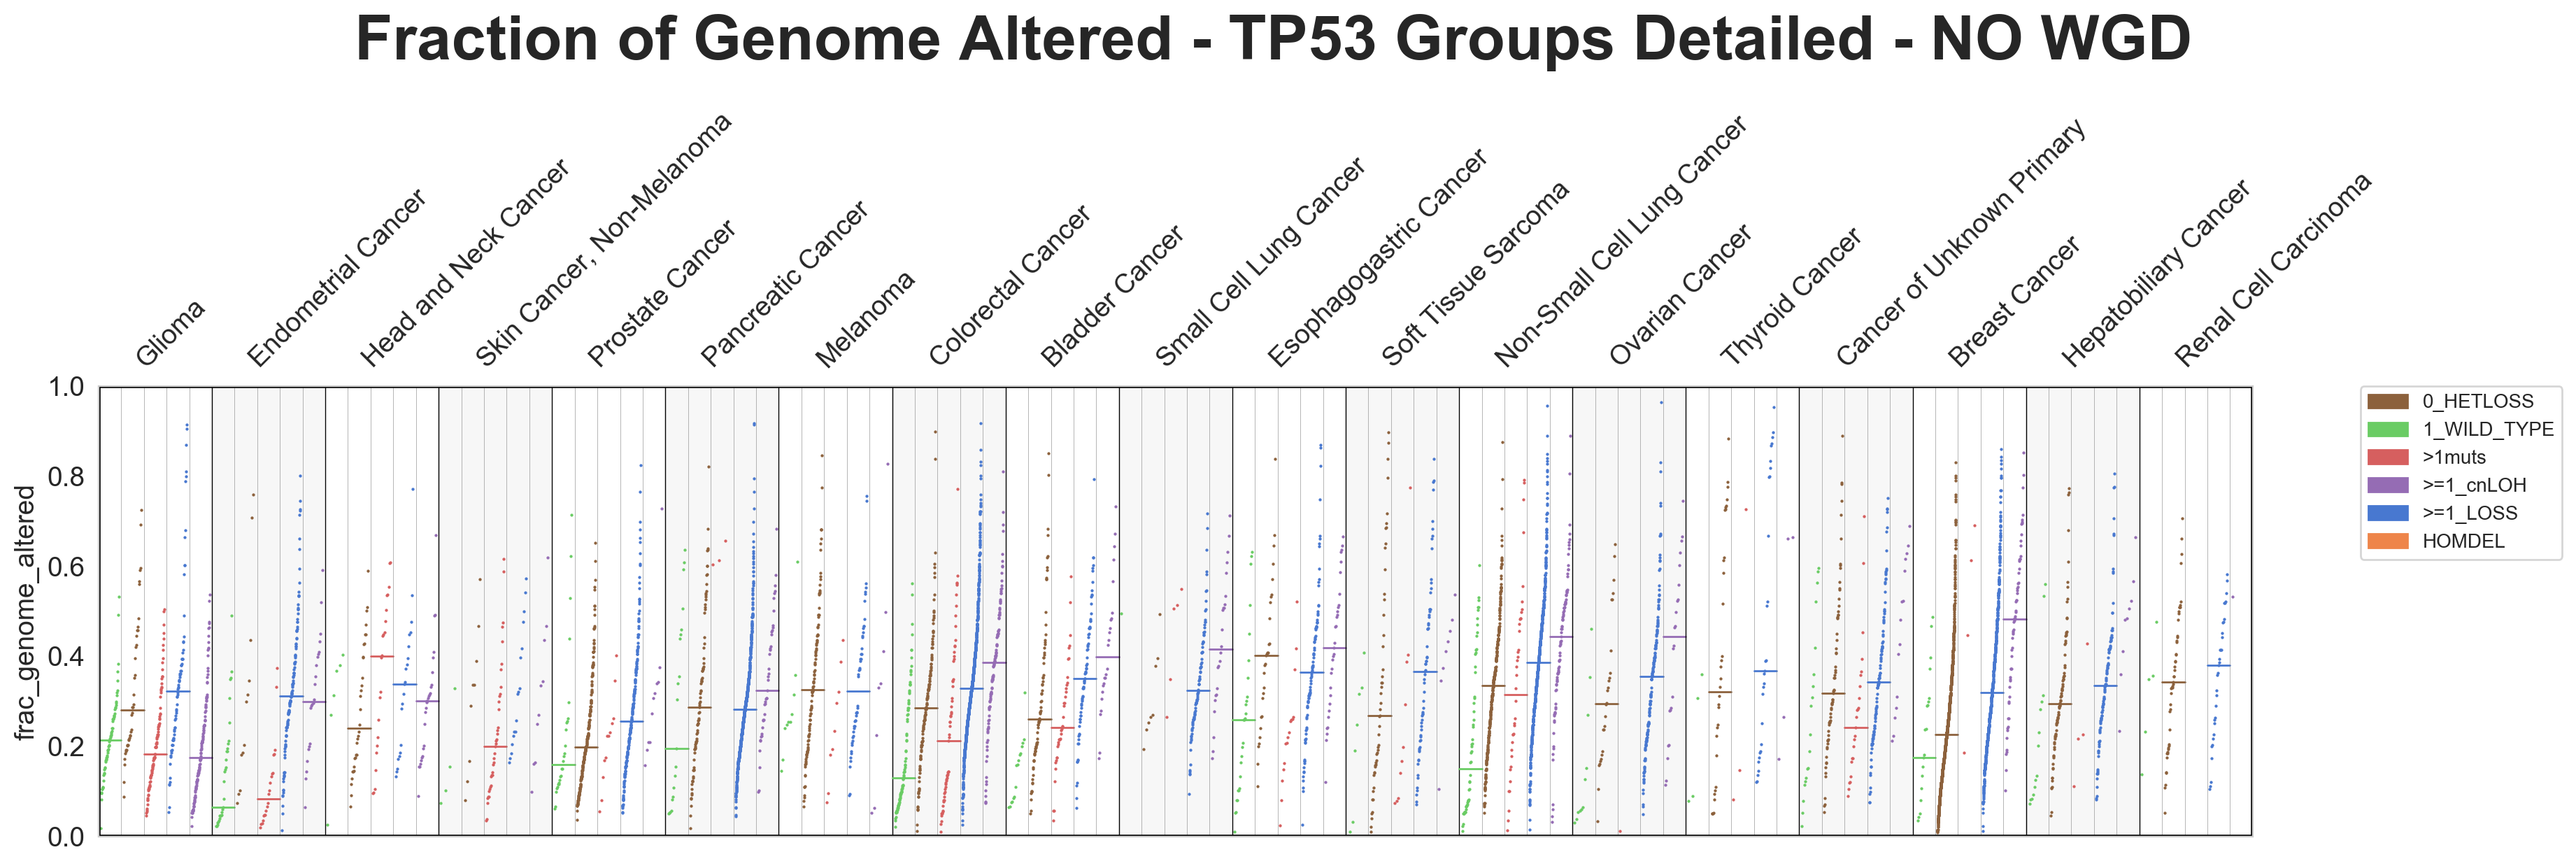

In [216]:
%%time
# Let's begin with. one subgroup : >=1_cnLOH
sns.set_style("whitegrid", {'grid.color': '1.'})

fig = plt.figure(figsize=(20,7))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)

import itertools
col = itertools.cycle(["#FFFFFF","#FFFFFF","#FFFFFF","#FFFFFF","#FFFFFF","#F7F7F7","#F7F7F7","#F7F7F7","#F7F7F7","#F7F7F7"])
labels = []

#order = medians.sort_values(ascending=False)
for i, (group, df) in enumerate(master_ordered.groupby(by="Cancer_Type", sort=False)):
    i = 5*i
    labels.append(group)
    
    # 1_WILD_TYPE Subgroup in GREEN
    
    df_mono = df[df['tp53_group'] =='1_WILD_TYPE']
    totalsamples_mono = df_mono.shape[0]
    df_mono = df_mono.sort_values(metrics)
    plt.axvspan(xmin=i-0.5,xmax=i+0.5,color=next(col),zorder=1)
    if totalsamples_mono>0:
        for j,(_,row) in enumerate(df_mono.iterrows()):
            plt.scatter(i-0.4+(j/totalsamples_mono)*0.8,row[metrics],color=palette['1_WILD_TYPE'],s=0.3,zorder=2)
        
        if df_mono.shape[0]>20:
            median_mono  = df_mono[metrics].median()
            plt.plot([i-0.5,i+0.5],[median_mono,median_mono],color=palette['1_WILD_TYPE'], linewidth=1)
    
    plt.plot([i+0.5,i+0.5],[0,1],color='#7F7F7F', linewidth=0.2)
    
    # 0_HETLOSS Subgroup in BROWN
    l=i+1
    df_mono = df[df['tp53_group'] =='0_HETLOSS']
    totalsamples_mono = df_mono.shape[0]
    df_mono = df_mono.sort_values(metrics)
    plt.axvspan(xmin=l-0.5,xmax=l+0.5,color=next(col),zorder=1)
    if totalsamples_mono>0:
        for j,(_,row) in enumerate(df_mono.iterrows()):
            plt.scatter(l-0.4+(j/totalsamples_mono)*0.8,row[metrics],color=palette['0_HETLOSS'],s=0.3,zorder=2)
        
        if df_mono.shape[0]>20:
            median_mono  = df_mono[metrics].median()
            plt.plot([l-0.5,l+0.5],[median_mono,median_mono],color=palette['0_HETLOSS'], linewidth=1)
    
    plt.plot([l+0.5,l+0.5],[0,1],color='#7F7F7F', linewidth=0.2)
    
    # >1muts Subgroup in RED
    k = i+2
    df_muts = df[df['tp53_group'] == '>1muts']
    totalsamples_muts = df_muts.shape[0]
    df_muts = df_muts.sort_values(metrics)
    plt.axvspan(xmin=k-0.5,xmax=k+0.5,color=next(col),zorder=1)
    if totalsamples_muts>0:
        for j,(_,row) in enumerate(df_muts.iterrows()):
            plt.scatter(k-0.4+(j/totalsamples_muts)*0.8,row[metrics],color=palette['>1muts'],s=0.3,zorder=2)
    
        if df_muts.shape[0]>20:
            median_muts  = df_muts[metrics].median()
            plt.plot([k-0.5,k+0.5],[median_muts,median_muts],color=palette['>1muts'], linewidth=1)
    
    plt.plot([k+0.5,k+0.5],[0,1],color='#7F7F7F', linewidth=0.2)
    
    # LOSS Subgroup in BLUE
    h = i+3
    df_loss = df[df['tp53_group']=='>=1_LOSS']
    totalsamples_loss = df_loss.shape[0]
    df_loss = df_loss.sort_values(metrics)
    plt.axvspan(xmin=h-0.5,xmax=h+0.5,color=next(col),zorder=1)
    if totalsamples_loss>0:
        for j,(_,row) in enumerate(df_loss.iterrows()):
            plt.scatter(h-0.4+(j/totalsamples_loss)*0.8,row[metrics],color=palette['>=1_LOSS'],s=0.3,zorder=2)
        
        if df_loss.shape[0]>20:
            median_loss  = df_loss[metrics].median()
            plt.plot([h-0.5,h+0.5],[median_loss,median_loss],color=palette['>=1_LOSS'], linewidth=1)
    
    plt.plot([h+0.5,h+0.5],[0,1],color='#7F7F7F', linewidth=0.2)
    
    # CNLOH Subgroup in PURPLE
    g = i+4
    df_cnloh = df[df['tp53_group'] == '>=1_cnLOH']
    totalsamples_cnloh = df_cnloh.shape[0]
    df_cnloh = df_cnloh.sort_values(metrics)
    plt.axvspan(xmin=g-0.5,xmax=g+0.5,color=next(col),zorder=1)
    if totalsamples_cnloh>0:
        for j,(_,row) in enumerate(df_cnloh.iterrows()):
            plt.scatter(g-0.4+(j/totalsamples_cnloh)*0.8,row[metrics],color=palette['>=1_cnLOH'],s=0.3,zorder=2)

        if df_cnloh.shape[0]>20:    
            median_cnloh  = df_cnloh[metrics].median()
            plt.plot([g-0.5,g+0.5],[median_cnloh,median_cnloh],color=palette['>=1_cnLOH'], linewidth=1)
    
    plt.plot([g+0.5,g+0.5],[0,1],color='black', linewidth=0.5) ##7F7F7F
  
num_dis = len(master[master['Cancer_Type'].isin(cancer_list)]["Cancer_Type"].unique())*5
real_labels = ['']*num_dis
for i,label in enumerate(labels):
    real_labels[5*i + 1] = label
    

ax.xaxis.tick_top()
plt.xticks([k for k in range(num_dis)], real_labels, rotation=45, ha="left", fontsize=14)
ax.xaxis.set_ticks_position('none')
plt.xlim(-0.5,num_dis-0.5)
plt.ylim(0,ylim)
# Grid
'''plt.plot([-0.5,num_dis+0.5],[0.2,0.2],color="black", linewidth=0.5, linestyle=':')
plt.plot([-0.5,num_dis+0.5],[0.4,0.4],color="black", linewidth=0.5, linestyle=':')
plt.plot([-0.5,num_dis+0.5],[0.6,0.6],color="black", linewidth=0.5, linestyle=':')
plt.plot([-0.5,num_dis+0.5],[0.8,0.8],color="black", linewidth=0.5, linestyle=':')
'''

# Border lines
plt.plot([-0.5,num_dis-0.5],[0,0],color="black", linewidth=2, linestyle='-')
plt.plot([-0.5,num_dis-0.5],[1,1],color="black", linewidth=2, linestyle='-')
plt.plot([-0.5,-0.5],[0,1],color="black", linewidth=2, linestyle='-')
plt.plot([num_dis-0.5,num_dis-0.5],[0,1],color="black", linewidth=2, linestyle='-')

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
plt.xlabel("")
plt.ylabel(metrics, fontsize=14)

palette = dict(zip(group_list, palette_list))
# Create legend handles manually
handles = [matplotlib.patches.Patch(color=palette[x], label=x) for x in palette.keys()]
# Create legend
ax.legend(handles=handles,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


fig.suptitle( 'Fraction of Genome Altered - TP53 Groups Detailed' + ' - NO WGD', fontsize=32,fontweight='bold')
fig.subplots_adjust(left=0.08, bottom=0.14, right=0.85, top=0.6, wspace=2, hspace=1)
fig.savefig('./gi_pancancer/no_wgd/pancancer_frac_all_no_wgd.pdf' , format='pdf')


In [25]:
set(master.tp53_res_group)

{None, 'no_tp53_res', 'tp53_res', 'uncertain'}

## Simplified Version
Here we create simple boxplots between the first and third quartiles. This plot allows us to remove the noise coming from the outliers

In [26]:
h = master[master['Cancer_Type'] == 'Breast Cancer'][master['tp53_group'] == '0_HETLOSS']
np.percentile(h[metrics], 50)

6.0

CPU times: user 1.83 s, sys: 200 ms, total: 2.03 s
Wall time: 729 ms


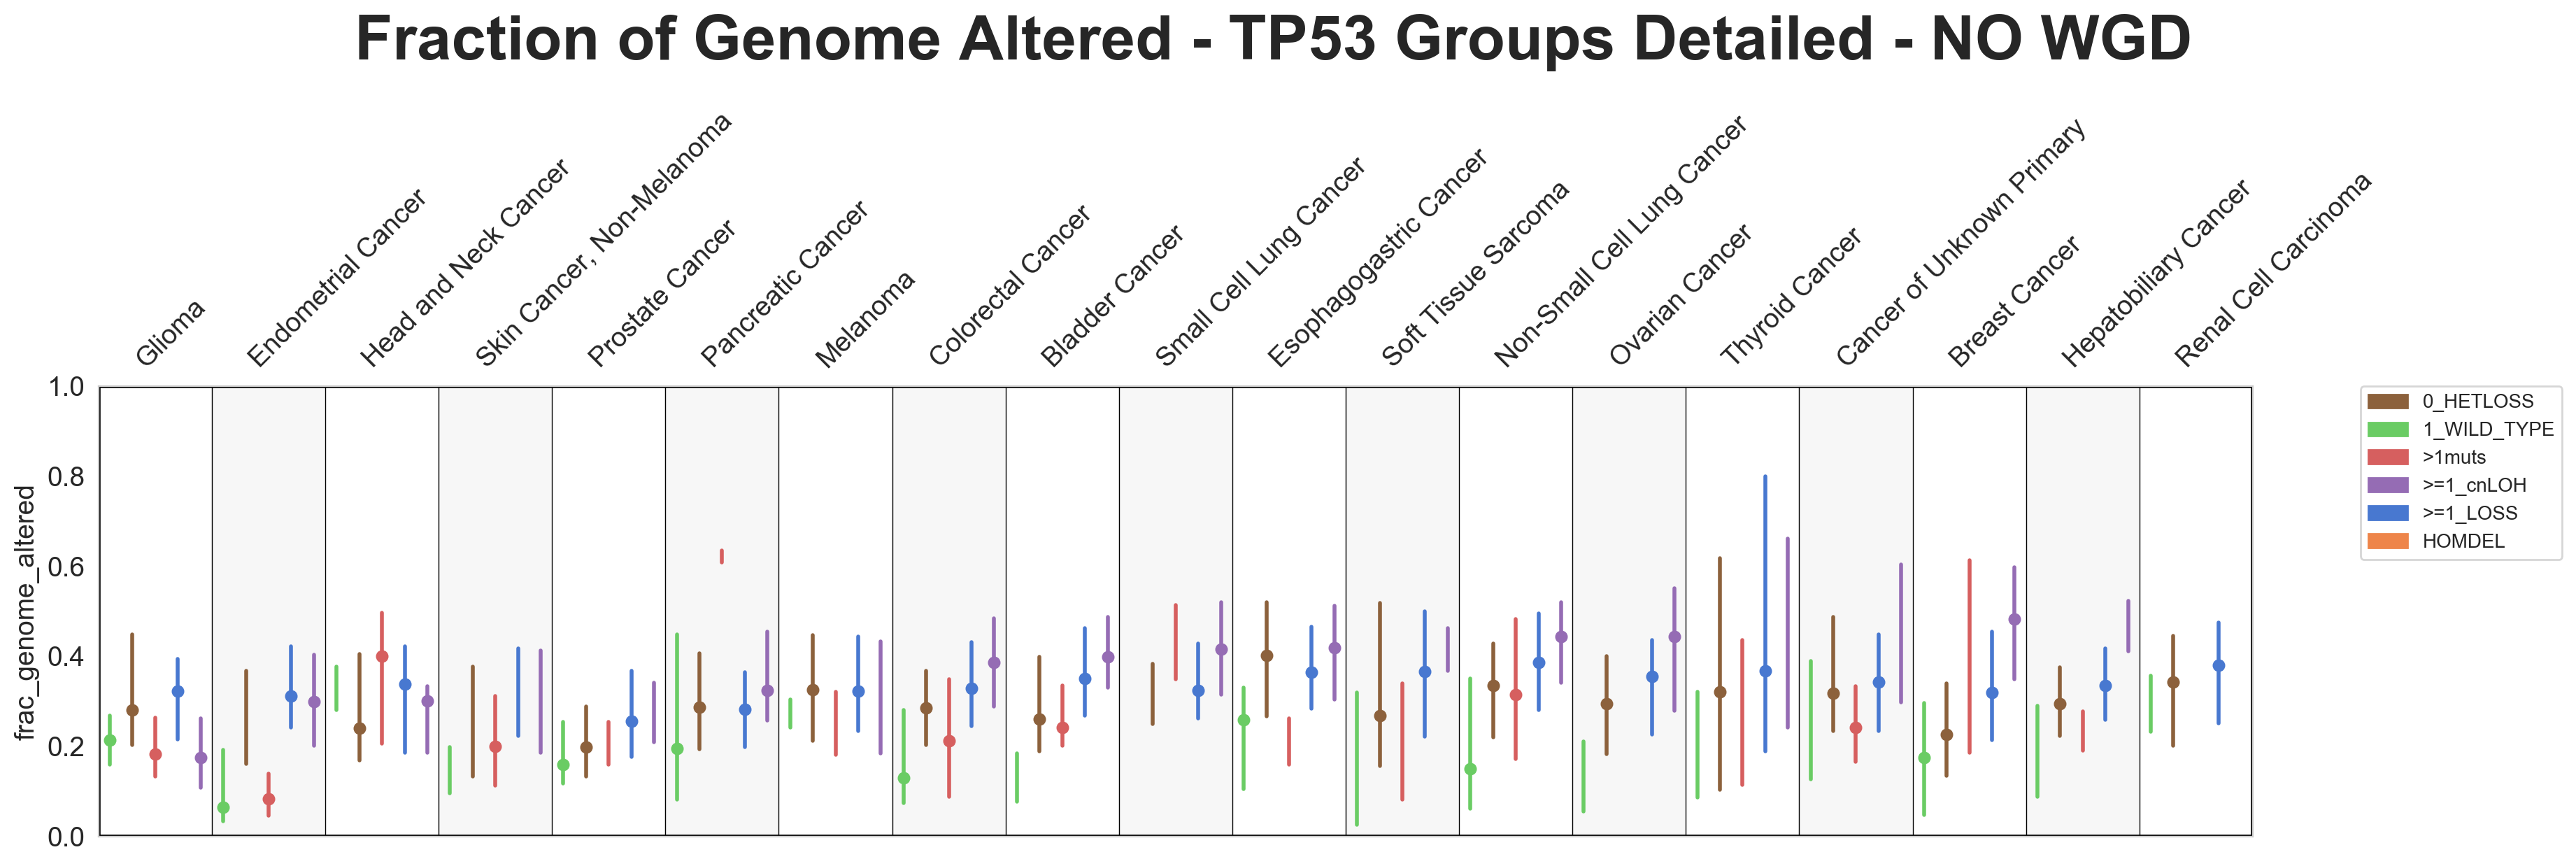

In [217]:
%%time
# Let's begin with. one subgroup : >=1_cnLOH
sns.set_style("whitegrid", {'grid.color': '1.'})

fig = plt.figure(figsize=(20,7))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)

import itertools
col = itertools.cycle(["#FFFFFF","#FFFFFF","#FFFFFF","#FFFFFF","#FFFFFF","#F7F7F7","#F7F7F7","#F7F7F7","#F7F7F7","#F7F7F7"])
labels = []

#order = medians.sort_values(ascending=False)
for i, (group, df) in enumerate(master_ordered.groupby(by="Cancer_Type", sort=False)):
    i = 5*i
    labels.append(group)
    
    # 1_WILD_TYPE Subgroup in GREEN
    df_mono = df[df['tp53_group'] =='1_WILD_TYPE']
    totalsamples_mono = df_mono.shape[0]
    df_mono = df_mono.sort_values(metrics)
    plt.axvspan(xmin=i-0.5,xmax=i+0.5,color=next(col),zorder=1)
    if totalsamples_mono>0:
        plt.plot([i,i], [np.percentile(df_mono[metrics], 25),np.percentile(df_mono[metrics], 75)], color=palette['1_WILD_TYPE'], linewidth=2)
        if df_mono.shape[0]>20:
            median_mono  = df_mono[metrics].median()
            plt.scatter(i,median_mono,color=palette['1_WILD_TYPE'],s=30,zorder=2, marker='o')
    
    # 0_HETLOSS Subgroup in BROWN
    l=i+1
    df_mono = df[df['tp53_group'] =='0_HETLOSS']
    totalsamples_mono = df_mono.shape[0]
    plt.axvspan(xmin=l-0.5,xmax=l+0.5,color=next(col),zorder=1)
    if totalsamples_mono>0:
        plt.plot([l,l], [np.percentile(df_mono[metrics], 25),np.percentile(df_mono[metrics], 75)], color=palette['0_HETLOSS'], linewidth=2)
        if df_mono.shape[0]>20:
            median_mono  = df_mono[metrics].median()
            plt.scatter(l,median_mono,color=palette['0_HETLOSS'],s=30,zorder=2, marker='o')
    
    #plt.plot([i+0.5,i+0.5],[0,1],color='#7F7F7F', linewidth=0.2)
    
    
    #plt.plot([l+0.5,l+0.5],[0,1],color='#7F7F7F', linewidth=0.2)
    
    # >1muts Subgroup in RED
    k = i+2
    df_muts = df[df['tp53_group'] == '>1muts']
    totalsamples_muts = df_muts.shape[0]
    df_muts = df_muts.sort_values(metrics)
    plt.axvspan(xmin=k-0.5,xmax=k+0.5,color=next(col),zorder=1)
    if totalsamples_muts>0:
        plt.plot([k,k], [np.percentile(df_muts[metrics], 25),np.percentile(df_muts[metrics], 75)], color=palette['>1muts'], linewidth=2)
        if df_muts.shape[0]>20:
            median_muts  = df_muts[metrics].median()
            plt.scatter(k,median_muts,color=palette['>1muts'],s=30,zorder=2, marker='o')
    
    #plt.plot([k+0.5,k+0.5],[0,1],color='#7F7F7F', linewidth=0.2)
    
    # LOSS Subgroup in BLUE
    h = i+3
    df_loss = df[df['tp53_group']=='>=1_LOSS']
    totalsamples_loss = df_loss.shape[0]
    df_loss = df_loss.sort_values(metrics)
    plt.axvspan(xmin=h-0.5,xmax=h+0.5,color=next(col),zorder=1)
    if totalsamples_loss>0:
        plt.plot([h,h], [np.percentile(df_loss[metrics], 25),np.percentile(df_loss[metrics], 75)], color=palette['>=1_LOSS'], linewidth=2)
        if df_loss.shape[0]>20:
            median_loss  = df_loss[metrics].median()
            plt.scatter(h,median_loss,color=palette['>=1_LOSS'],s=30,zorder=2, marker='o')
        
            #plt.plot([h-0.3,h+0.3],[median_loss,median_loss],color=palette['>=1_LOSS'], linewidth=1)
    
    #plt.plot([h+0.5,h+0.5],[0,1],color='#7F7F7F', linewidth=0.2)
    
    # CNLOH Subgroup in PURPLE
    g = i+4
    df_cnloh = df[df['tp53_group'] == '>=1_cnLOH']
    totalsamples_cnloh = df_cnloh.shape[0]
    df_cnloh = df_cnloh.sort_values(metrics)
    plt.axvspan(xmin=g-0.5,xmax=g+0.5,color=next(col),zorder=1)
    if totalsamples_cnloh>0:
        plt.plot([g,g], [np.percentile(df_cnloh[metrics], 25),np.percentile(df_cnloh[metrics], 75)], color=palette['>=1_cnLOH'], linewidth=2)
        if df_cnloh.shape[0]>20:    
            median_cnloh  = df_cnloh[metrics].median()
            plt.scatter(g,median_cnloh,color=palette['>=1_cnLOH'],s=30,zorder=2, marker='o')
    
    plt.plot([g+0.5,g+0.5],[0,ylim],color='black', linewidth=0.5) ##7F7F7F
  
num_dis = len(master[master['Cancer_Type'].isin(cancer_list)]["Cancer_Type"].unique())*5
real_labels = ['']*num_dis
for i,label in enumerate(labels):
    real_labels[5*i + 1] = label
    

ax.xaxis.tick_top()
plt.xticks([k for k in range(num_dis)], real_labels, rotation=45, ha="left", fontsize=14)
ax.xaxis.set_ticks_position('none')
plt.xlim(-0.5,num_dis-0.5)
plt.ylim(0,ylim)
# Grid
'''plt.plot([-0.5,num_dis+0.5],[0.2,0.2],color="black", linewidth=0.5, linestyle=':')
plt.plot([-0.5,num_dis+0.5],[0.4,0.4],color="black", linewidth=0.5, linestyle=':')
plt.plot([-0.5,num_dis+0.5],[0.6,0.6],color="black", linewidth=0.5, linestyle=':')
plt.plot([-0.5,num_dis+0.5],[0.8,0.8],color="black", linewidth=0.5, linestyle=':')
'''

# Border lines
plt.plot([-0.5,num_dis-0.5],[0,0],color="black", linewidth=2, linestyle='-')
plt.plot([-0.5,num_dis-0.5],[ylim,ylim],color="black", linewidth=2, linestyle='-')
plt.plot([-0.5,-0.5],[0,ylim],color="black", linewidth=2, linestyle='-')
plt.plot([num_dis-0.5,num_dis-0.5],[0,ylim],color="black", linewidth=2, linestyle='-')

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
plt.xlabel("")
plt.ylabel(metrics, fontsize=14)

palette = dict(zip(group_list, palette_list))
# Create legend handles manually
handles = [matplotlib.patches.Patch(color=palette[x], label=x) for x in palette.keys()]
# Create legend
ax.legend(handles=handles,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

fig.suptitle( 'Fraction of Genome Altered - TP53 Groups Detailed' + ' - NO WGD', fontsize=32,fontweight='bold')
fig.subplots_adjust(left=0.08, bottom=0.14, right=0.85, top=0.6, wspace=2, hspace=1)
fig.savefig('./gi_pancancer/no_wgd/pancancer_frac_simple_no_wgd.pdf' , format='pdf')


# WGD Cohort

In [3]:
master_wgd = pd.read_pickle(data_path + 'impact-facets-tp53/processed/wgd/master_wgd.pkl')

In [32]:
master_wgd

Sample_Id           Tumor_Id Patient_Id  \
0     P-0025956-T01-IM6_P-0025956-N01-IM6  P-0025956-T01-IM6  P-0025956   
1     P-0036909-T01-IM6_P-0036909-N01-IM6  P-0036909-T01-IM6  P-0036909   
2     P-0023546-T01-IM6_P-0023546-N01-IM6  P-0023546-T01-IM6  P-0023546   
3     P-0023546-T02-IM6_P-0023546-N01-IM6  P-0023546-T02-IM6  P-0023546   
4     P-0018837-T01-IM6_P-0018837-N01-IM6  P-0018837-T01-IM6  P-0018837   
...                                   ...                ...        ...   
6362  P-0050671-T01-IM6_P-0050671-N01-IM6  P-0050671-T01-IM6  P-0050671   
6363  P-0009110-T02-IM6_P-0009110-N01-IM6  P-0009110-T02-IM6  P-0009110   
6364  P-0050668-T01-IM6_P-0050668-N01-IM6  P-0050668-T01-IM6  P-0050668   
6365  P-0050675-T01-IM6_P-0050675-N01-IM6  P-0050675-T01-IM6  P-0050675   
6366  P-0050660-T01-IM6_P-0050660-N01-IM6  P-0050660-T01-IM6  P-0050660   

                     Cancer_Type               Cancer_Type_Detailed  \
0     Non-Small Cell Lung Cancer                Lung Adenocarcinoma   
1     Non-Small Cell Lung Cancer                Lung Adenocarcinoma   
2                Prostate Cancer  Prostate Neuroendocrine Carcinoma   
3                Prostate Cancer            Prostate Adenocarcinoma   
4              Colorectal Cancer               Colon Adenocarcinoma   
...                          ...                                ...   
6362               Breast Cancer          Invasive Breast Carcinoma   
6363  Non-Small Cell Lung Cancer                Lung Adenocarcinoma   
6364  Non-Small Cell Lung Cancer       Lung Squamous Cell Carcinoma   
6365   Cancer of Unknown Primary          Cancer of Unknown Primary   
6366              Bladder Cancer       Bladder Urothelial Carcinoma   

      Patient_Current_Age Sample_Type    purity    ploidy  \
0                    71.0     Primary  0.273767  3.496971   
1                    47.0  Metastasis  0.391316  2.871793   
2                    50.0     Primary  0.865628  3.115253   
3                    50.0     Primary  0.312907  3.136841   
4                    60.0     Primary  0.351778  3.727190   
...                   ...         ...       ...       ...   
6362                 34.0  Metastasis  0.300360  3.776265   
6363                 57.0  Metastasis  0.239690  3.480349   
6364                 73.0     Primary  0.211949  3.144416   
6365                 64.0     Primary  0.386871  2.760248   
6366                 70.0     Primary  0.683828  3.459433   

      Overall_Survival_Months Overall_Survival_Status  MSI_Score MSI_Type  \
0                       3.584                DECEASED       0.00   Stable   
1                      14.137                  LIVING       0.37   Stable   
2                       4.800                DECEASED       2.37   Stable   
3                       4.800                DECEASED       0.82   Stable   
4                      34.060                  LIVING       0.45   Stable   
...                       ...                     ...        ...      ...   
6362                    2.005                  LIVING       0.05   Stable   
6363                   49.414                  LIVING       0.00   Stable   
6364                    1.710                  LIVING       0.00   Stable   
6365                    1.973                  LIVING       1.32   Stable   
6366                    2.038                  LIVING       0.41   Stable   

      TMB_Score                       tp53_key_1          tp53_vc_1  \
0           5.3                             None               None   
1           3.5  P-0036909-T01-IM617_7577121_G_A  Missense_Mutation   
2           3.5  P-0023546-T01-IM617_7578442_T_C  Missense_Mutation   
3           2.6  P-0023546-T02-IM617_7578442_T_C  Missense_Mutation   
4           5.3  P-0018837-T01-IM617_7578406_C_T  Missense_Mutation   
...         ...                              ...                ...   
6362        7.0                             None               None   
6363       30.7  P-0009110-T02-IM617_7576853_C_A  Mi

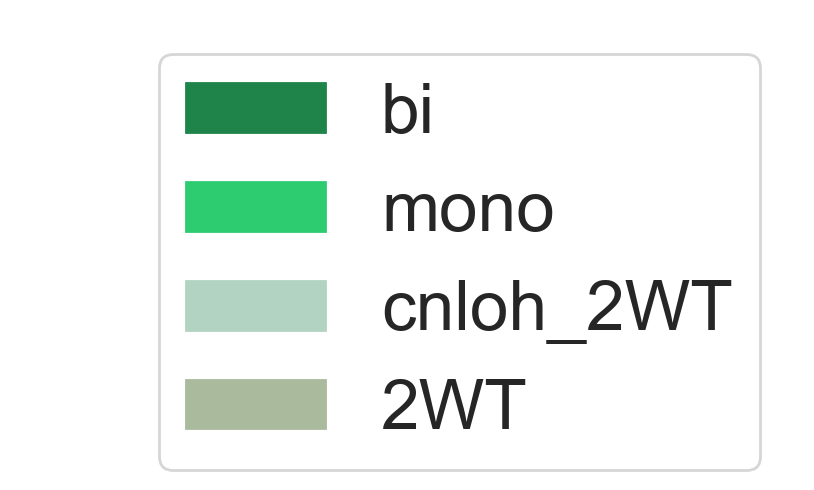

In [4]:
fig, ax = plt.subplots(figsize=(5,1))
# Create a color palette


res_palette_list = ['#1E8449','#2ECC71', '#B2D3C2', '#A9BA9D']
res_group_list = ['bi', 'mono', 'cnloh_2WT', '2WT']

palette = dict(zip(res_group_list, res_palette_list))
# Create legend handles manually
handles = [matplotlib.patches.Patch(color=palette[x], label=x) for x in palette.keys()]
# Create legend
ax.legend(handles=handles, fontsize=25, loc='centered')
# Get current axes object and turn off axis
ax.set_axis_off()
plt.show()

## Subgroup Comparison
First we want to see if significant Genome Instability differences are present across subgroups, without splitting on cancer types.

In [19]:
def boxplot_sampletype(df: pd.DataFrame, metrics: str, palette,  group:str,group_list, figsize= (10,3), title: str = '',tp53_metrics=False, title_font: int=12, xlim=[0,1], continuous= False):
    fig=plt.figure(figsize=figsize)
    ax = plt.subplot2grid(shape=(2,1), loc=(0,0), colspan=1)
    

    groupby = get_groupby(df, group, 'count')

    if tp53_metrics:
        groupby= get_groupby(df[~df[metrics + '_1'].isna()], group, 'count')
        data_1 =  pd.DataFrame(df[['Tumor_Id', metrics + '_1']])
        data_1.columns = ['Tumor_Id', metrics]
        data_2 = pd.DataFrame(df[['Tumor_Id', metrics + '_2']])
        data_2.columns = ['Tumor_Id', metrics]
        data_3 = pd.DataFrame(df[['Tumor_Id', metrics + '_3']])
        data_3.columns = ['Tumor_Id', metrics]
        data_4 = pd.DataFrame(df[['Tumor_Id', metrics + '_4']])
        data_4.columns = ['Tumor_Id', metrics]
        data_5 = pd.DataFrame(df[['Tumor_Id', metrics + '_5']])
        data_5.columns = ['Tumor_Id', metrics]
        data_tot = data_1.append(data_2)
        data_tot = data_tot.append(data_3)
        data_tot = data_tot.append(data_4)
        data_tot = data_tot.append(data_5)

        df = pd.merge(left=data_tot, right=df[['Tumor_Id','tp53_cn_state', 'tp53_tcn', group]],how='left', left_on='Tumor_Id',right_on='Tumor_Id')

    if continuous: sns.violinplot(x=metrics, y=group,data=df,ax=ax, dodge=False,order=group_list, palette=palette).set_title(title, weight='bold', fontsize=title_font)
    else: sns.boxplot(y=metrics, x=group,data=df,ax=ax, dodge=False,order=group_list, palette=palette).set_title(title, weight='bold', fontsize=title_font)

    '''try:
        ax.set_yticklabels(['Primary (' + str(int(groupby.loc['Primary'])) + ')',
                            'Metastasis (' + str(int(groupby.loc['Metastasis'])) + ')'], 
                            fontsize=10)
    except: pass
    '''
    style(ax)
    ax.set_ylim(xlim)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    return fig, ax

### LOH Status

Text(0, 0.5, 'Fraction of Genome Altered')

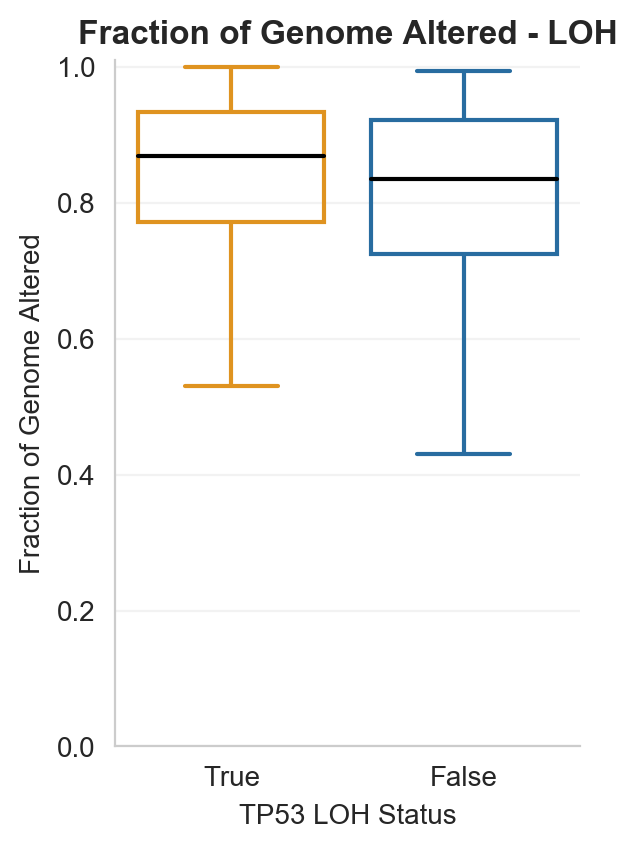

In [20]:
fig, ax = boxplot_sampletype(df=master_wgd,
                   metrics='frac_genome_altered',
                   palette=palette_loh,
                   group='tp53_loh_status',
                   group_list= loh_list,
                   figsize= (3,10), 
                   title= 'Fraction of Genome Altered - LOH',
                   tp53_metrics=False,
                   title_font=12,
                   xlim=[0,1.01], 
                   continuous= False)

ax.set_xlabel('TP53 LOH Status')
ax.set_ylabel('Fraction of Genome Altered')

In [41]:
# Let's give a look at medians and statistics

def get_statistics(group:str, metrics: str, group_list: list):
    group_1 = master_wgd[master_wgd[group] == group_list[0]][metrics]
    group_2 = master_wgd[master_wgd[group] == group_list[1]][metrics]

    median_1 = group_1.median()
    median_2 = group_2.median()

    statistic, p_value = ranksums(group_1.dropna().values,group_2.dropna().values)
    
    results = [['', 'size', metrics],
               [group_list[0], group_1.shape[0], median_1],
               [group_list[1], group_2.shape[0], median_2],
               ['', 'Statistics', 'p-value'],
               ['', statistic, p_value]]


    return pd.DataFrame(results)

In [42]:
 get_statistics(group='tp53_loh_status',
                metrics='frac_genome_altered',
                group_list=[True, False])

0           1                    2
0               size  frac_genome_altered
1   True        4659                0.869
2  False        1708                0.835
3         Statistics              p-value
4            6.91852          4.56395e-12

### PRE WGD  TP53 Allelic State

Text(0, 0.5, 'Fraction of Genome Altered')

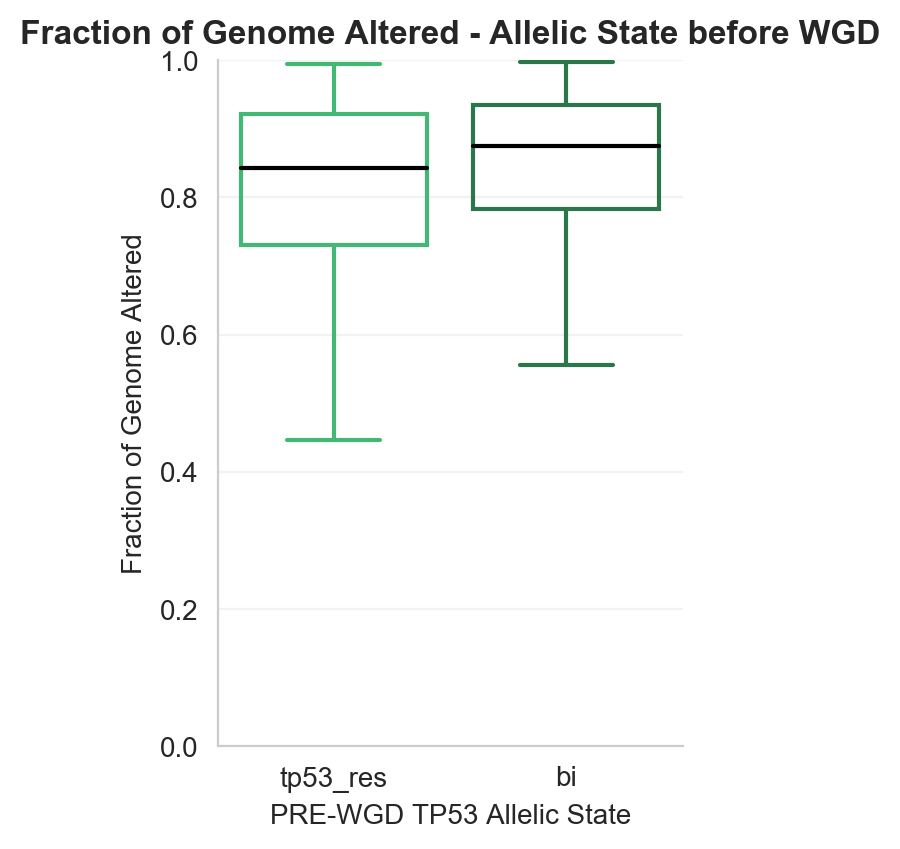

In [32]:
fig, ax = boxplot_sampletype(df=master_wgd,
                   metrics='frac_genome_altered',
                   palette=palette_bi,
                   group='prewgd_tp53_group_1',
                   group_list= bi_list,
                   figsize= (3,10), 
                   title= 'Fraction of Genome Altered - Allelic State before WGD',
                   tp53_metrics=False,
                   title_font=12,
                   xlim=[0,1], 
                   continuous= False)
ax.set_xlabel('PRE-WGD TP53 Allelic State')
ax.set_ylabel('Fraction of Genome Altered')

In [43]:
get_statistics(group='prewgd_tp53_group_1',
                metrics='frac_genome_altered',
                group_list=['bi', 'tp53_res'])

0           1                    2
0                  size  frac_genome_altered
1        bi        3307                0.874
2  tp53_res        2789                0.842
3            Statistics              p-value
4               8.47686          2.31348e-17

### PRE WGD TP53 Allelic State Detailed

Text(0, 0.5, 'Fraction of Genome Altered')

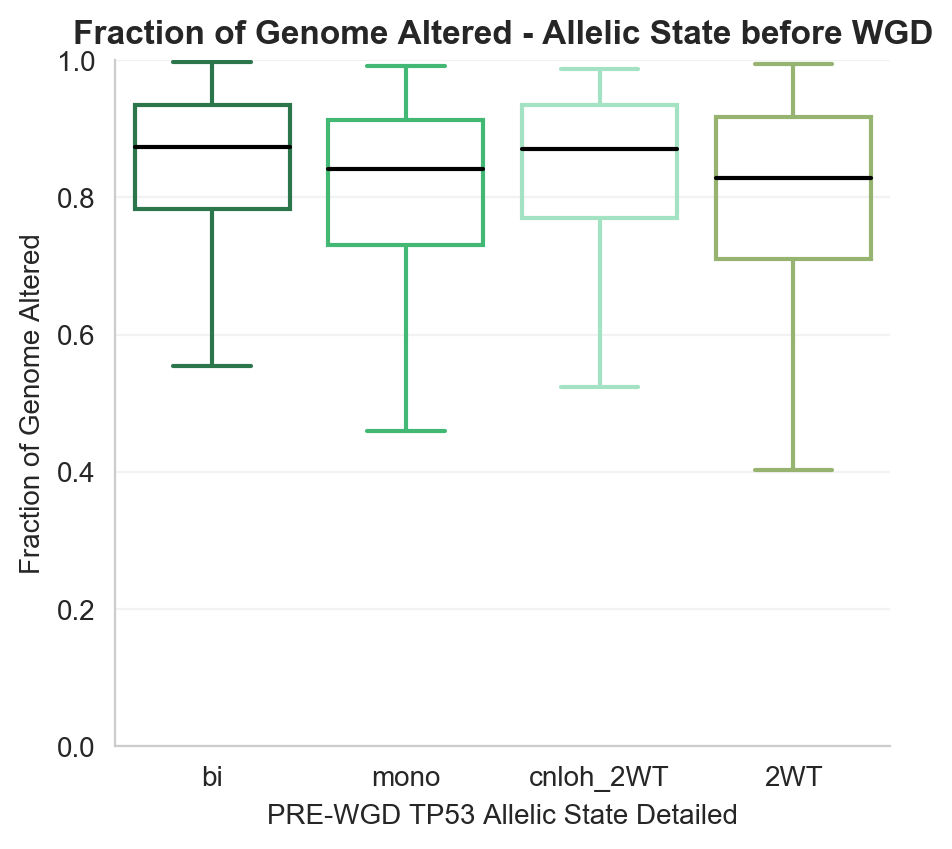

In [22]:
fig, ax = boxplot_sampletype(df=master_wgd,
                   metrics='frac_genome_altered',
                   palette=palette_state,
                   group='prewgd_tp53_group_2',
                   group_list= state_list,
                   figsize= (5,10), 
                   title= 'Fraction of Genome Altered - Allelic State before WGD',
                   tp53_metrics=False,
                   title_font=12,
                   xlim=[0,1], 
                   continuous= False)
ax.set_xlabel('PRE-WGD TP53 Allelic State Detailed')
ax.set_ylabel('Fraction of Genome Altered')

**Conclusions:**

The first thing we can affirm is that Fraction of Genome Altered is VERY high in WGD cohort compared to the Non-WGD cohort.

Then, we see Genome Instability differences between the subgroups:
* TP53 LOH samples tend to have higher GI than TP53 Non LOH samples
* Pre WGD TP53 Bi allelic samples are more unstable than Pre WGD TP53 Residual samples
* cnloh_2WT tend to have higher GI than mono

## Genome Instability Plot across cancers
Let's see now what happens when we plot those metrics per cancer in the same plots as we did above.
Do we see different trneds between Bi and Tp53_res accross cancers?

Let's just have a look to the WGD distributions per cancer

Text(0.5, 1.0, 'WGD Proportion per Cancer Type')

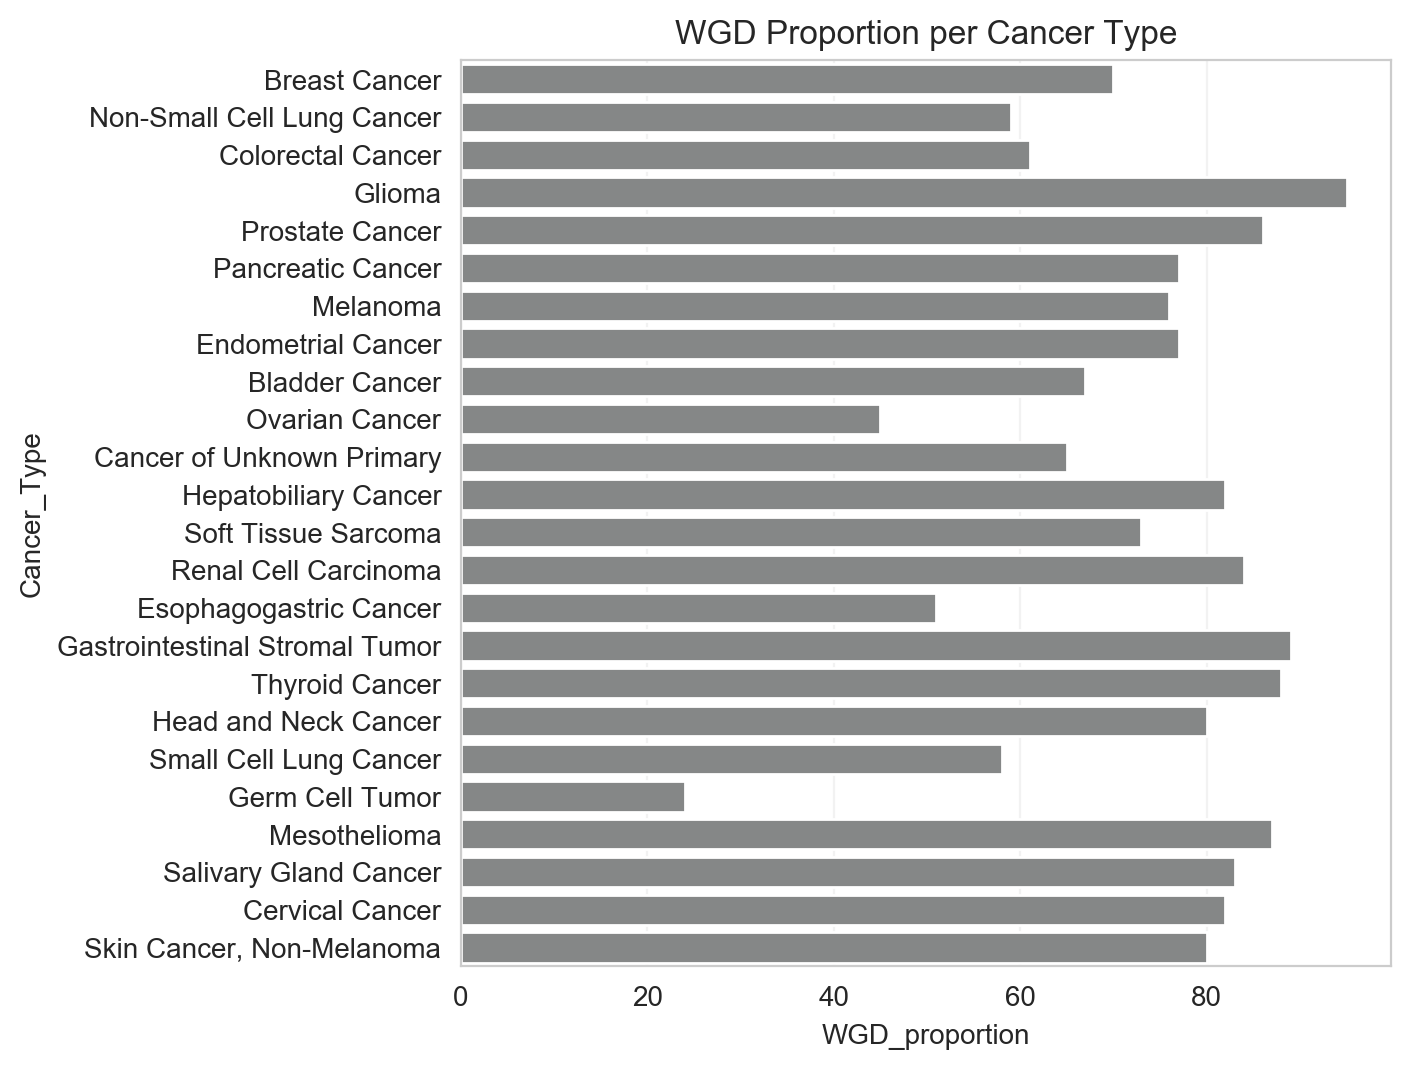

In [126]:
cancer_count_no_wgd = get_groupby(master_wgd, 'Cancer_Type', 'count').sort_values(by='count', ascending = False)
cancer_count_wgd = get_groupby(master, 'Cancer_Type', 'count').sort_values(by='count', ascending = False)

cancer_count = pd.merge(cancer_count_no_wgd, cancer_count_wgd, on='Cancer_Type')
cancer_count.columns=['NO_WGD', 'WGD']

cancer_count['total'] = cancer_count.sum(axis=1)
cancer_count = cancer_count.sort_values(by='total', ascending=False)
cancer_count['WGD_proportion'] = cancer_count.apply(lambda x: 100 * round(x.WGD/x.total, 2), axis=1)

cancer_count_list = cancer_count[cancer_count['total'] >= 160]

ax = sns.barplot(y=cancer_count_list.index, x='WGD_proportion',data=cancer_count_list[['WGD_proportion']], color='#7F8C8D', saturation=.2)
ax.set_title('WGD Proportion per Cancer Type')

In [134]:
# We define a list of cancer types we will plot: 23 cancers
cancer_list_wgd = cancer_count_wgd[cancer_count_wgd['count'] > 120].index.tolist()

In [135]:
master_wgd_cancers = master_wgd[master_wgd['Cancer_Type'].isin(cancer_list_wgd)]

### LOH status comparison

We order the cancer types so that the LOH medians are ascending in our plot

In [146]:
# Filter and order the samples in order to plot with decreasing medians on the cnloh subgroup
master_cancers_loh = master_wgd_cancers[master_wgd_cancers['tp53_loh_status'] == True]
cancer_order = master_cancers_loh.groupby('Cancer_Type')['frac_genome_altered']\
                                .apply(np.median)\
                                .sort_values(ascending=True)\
                                .index\
                                .tolist()
samples_list_ordered=[]
for cancer in cancer_order:
    samples_list_ordered = samples_list_ordered + master_wgd_cancers[master_wgd_cancers['Cancer_Type'] == cancer].index.tolist()
#samples_list_ordered

master_ordered = master_wgd_cancers.reindex(samples_list_ordered)

CPU times: user 1min 11s, sys: 8.39 s, total: 1min 19s
Wall time: 29.3 s


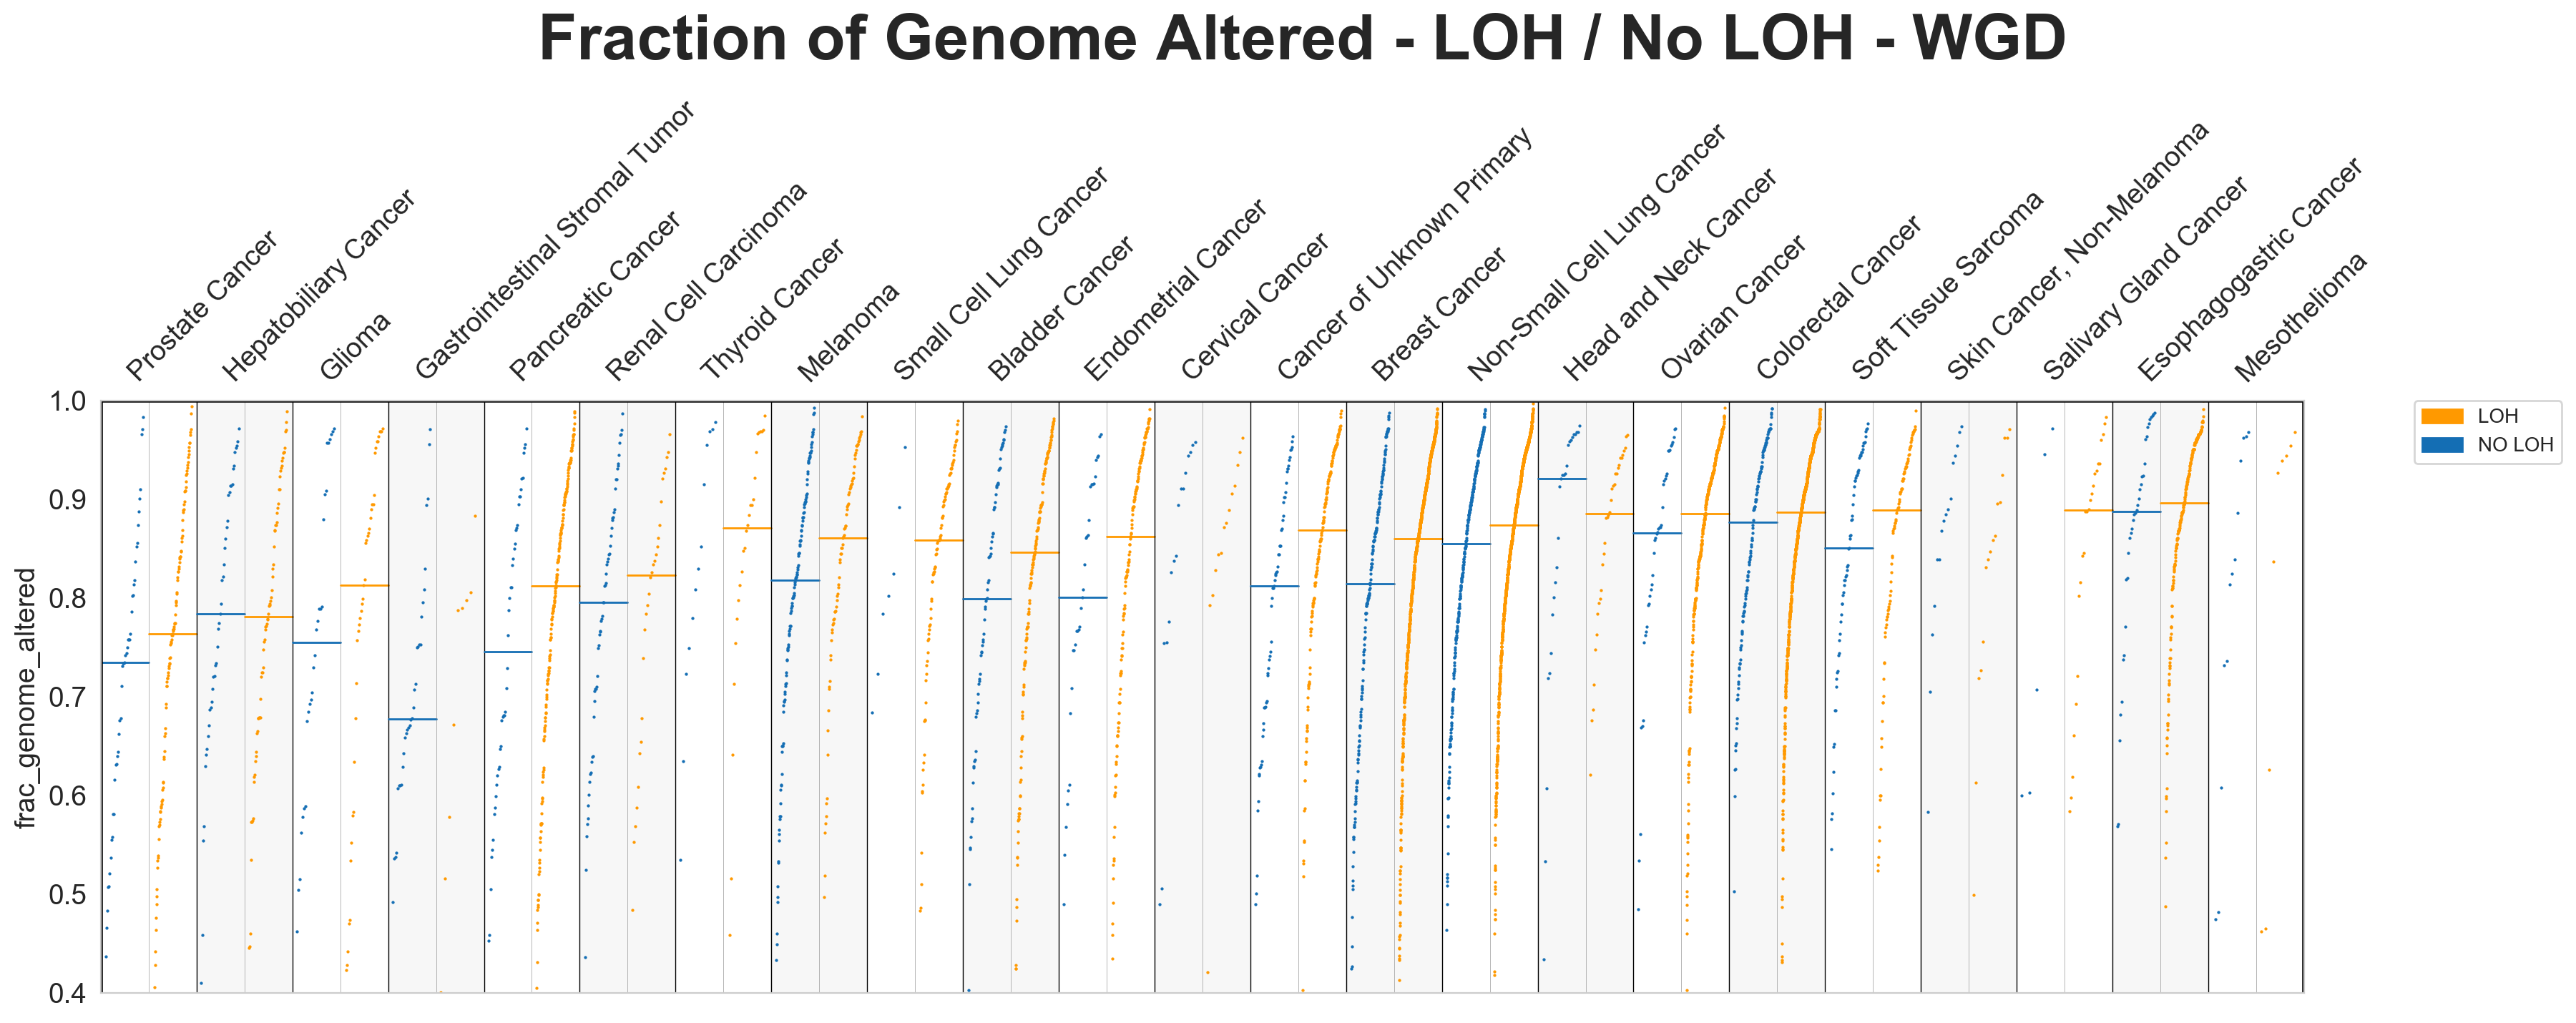

In [187]:
%%time
# Let's begin with. one subgroup : >=1_cnLOH
sns.set_style("whitegrid", {'grid.color': '1.'})

fig = plt.figure(figsize=(20,9))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)

import itertools
col = itertools.cycle(["#FFFFFF","#FFFFFF","#F7F7F7","#F7F7F7"])
labels = []

#order = medians.sort_values(ascending=False)
for i, (group, df) in enumerate(master_ordered.groupby(by="Cancer_Type", sort=False)):
    i = 2*i
    labels.append(group)
    
    # Non LOH Subgroup in Blue
    df_mono = df[df['tp53_loh_status'] == False]
    totalsamples_mono = df_mono.shape[0]
    df_mono = df_mono.sort_values(metrics)
    plt.axvspan(xmin=i-0.5,xmax=i+0.5,color=next(col),zorder=1)
    if totalsamples_mono>0:
        for j,(_,row) in enumerate(df_mono.iterrows()):
            plt.scatter(i-0.4+(j/totalsamples_mono)*0.8,row[metrics],color=palette_loh[False],s=0.3,zorder=2)
        
        if df_mono.shape[0]>20:
            median_mono  = df_mono[metrics].median()
            plt.plot([i-0.5,i+0.5],[median_mono,median_mono],color=palette_loh[False], linewidth=1)
    
    plt.plot([i+0.5,i+0.5],[0,1],color='#7F7F7F', linewidth=0.2)
    
    # LOH Subgroup in Orange
    k = i+1
    df_muts = df[df['tp53_loh_status'] == True]
    totalsamples_muts = df_muts.shape[0]
    df_muts = df_muts.sort_values(metrics)
    plt.axvspan(xmin=k-0.5,xmax=k+0.5,color=next(col),zorder=1)
    if totalsamples_muts>0:
        for j,(_,row) in enumerate(df_muts.iterrows()):
            plt.scatter(k-0.4+(j/totalsamples_muts)*0.8,row[metrics],color=palette_loh[True],s=0.3,zorder=2)
    
        if df_muts.shape[0]>20:
            median_muts  = df_muts[metrics].median()
            plt.plot([k-0.5,k+0.5],[median_muts,median_muts],color=palette_loh[True], linewidth=1)
    
    plt.plot([k+0.5,k+0.5],[0,1],color='black', linewidth=0.5)


  
num_dis = len(master_wgd_cancers["Cancer_Type"].unique())*2
real_labels = ['']*num_dis
for i,label in enumerate(labels):
    real_labels[2*i] = label
    

ax.xaxis.tick_top()
plt.xticks([k for k in range(num_dis)], real_labels, rotation=45, ha="left", fontsize=14)
ax.xaxis.set_ticks_position('none')
plt.xlim(-0.5,num_dis-0.5)
plt.ylim(0.4,1)

# Border lines
plt.plot([-0.5,num_dis-0.5],[0,0],color="black", linewidth=2, linestyle='-')
plt.plot([-0.5,num_dis-0.5],[1,1],color="black", linewidth=2, linestyle='-')
plt.plot([-0.5,-0.5],[0,1],color="black", linewidth=2, linestyle='-')
plt.plot([num_dis-0.5,num_dis-0.5],[0,1],color="black", linewidth=2, linestyle='-')

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
plt.xlabel("")
plt.ylabel(metrics, fontsize=14)

palette_ = dict(zip(['LOH', 'NO LOH'], loh_palette_list))
# Create legend handles manually
handles = [matplotlib.patches.Patch(color=palette_[x], label=x) for x in palette_.keys()]
# Create legend
ax.legend(handles=handles,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


fig.suptitle('Fraction of Genome Altered - LOH / No LOH' + ' - WGD', fontsize=32,fontweight='bold', y=0.9)
fig.subplots_adjust(left=0.08, bottom=0.14, right=0.85, top=0.6, wspace=2, hspace=1.5)
fig.savefig('./gi_pancancer/wgd/pancancer_frac_loh_wgd.pdf' , format='pdf')

### Pre WGD TP53 Allelic State

In [169]:
# First we order by ascending BI-Allelic frac_genome_altered Median
# Filter and order the samples in order to plot with decreasing medians on the cnloh subgroup
master_cancers_loh = master_wgd_cancers[master_wgd_cancers['prewgd_tp53_group_1'] == 'bi']
cancer_order = master_cancers_loh.groupby('Cancer_Type')['frac_genome_altered']\
                                .apply(np.median)\
                                .sort_values(ascending=True)\
                                .index\
                                .tolist()
samples_list_ordered=[]
for cancer in cancer_order:
    samples_list_ordered = samples_list_ordered + master_wgd_cancers[master_wgd_cancers['Cancer_Type'] == cancer].index.tolist()
#samples_list_ordered

master_ordered = master_wgd_cancers.reindex(samples_list_ordered)

CPU times: user 1min 10s, sys: 8.95 s, total: 1min 19s
Wall time: 30 s


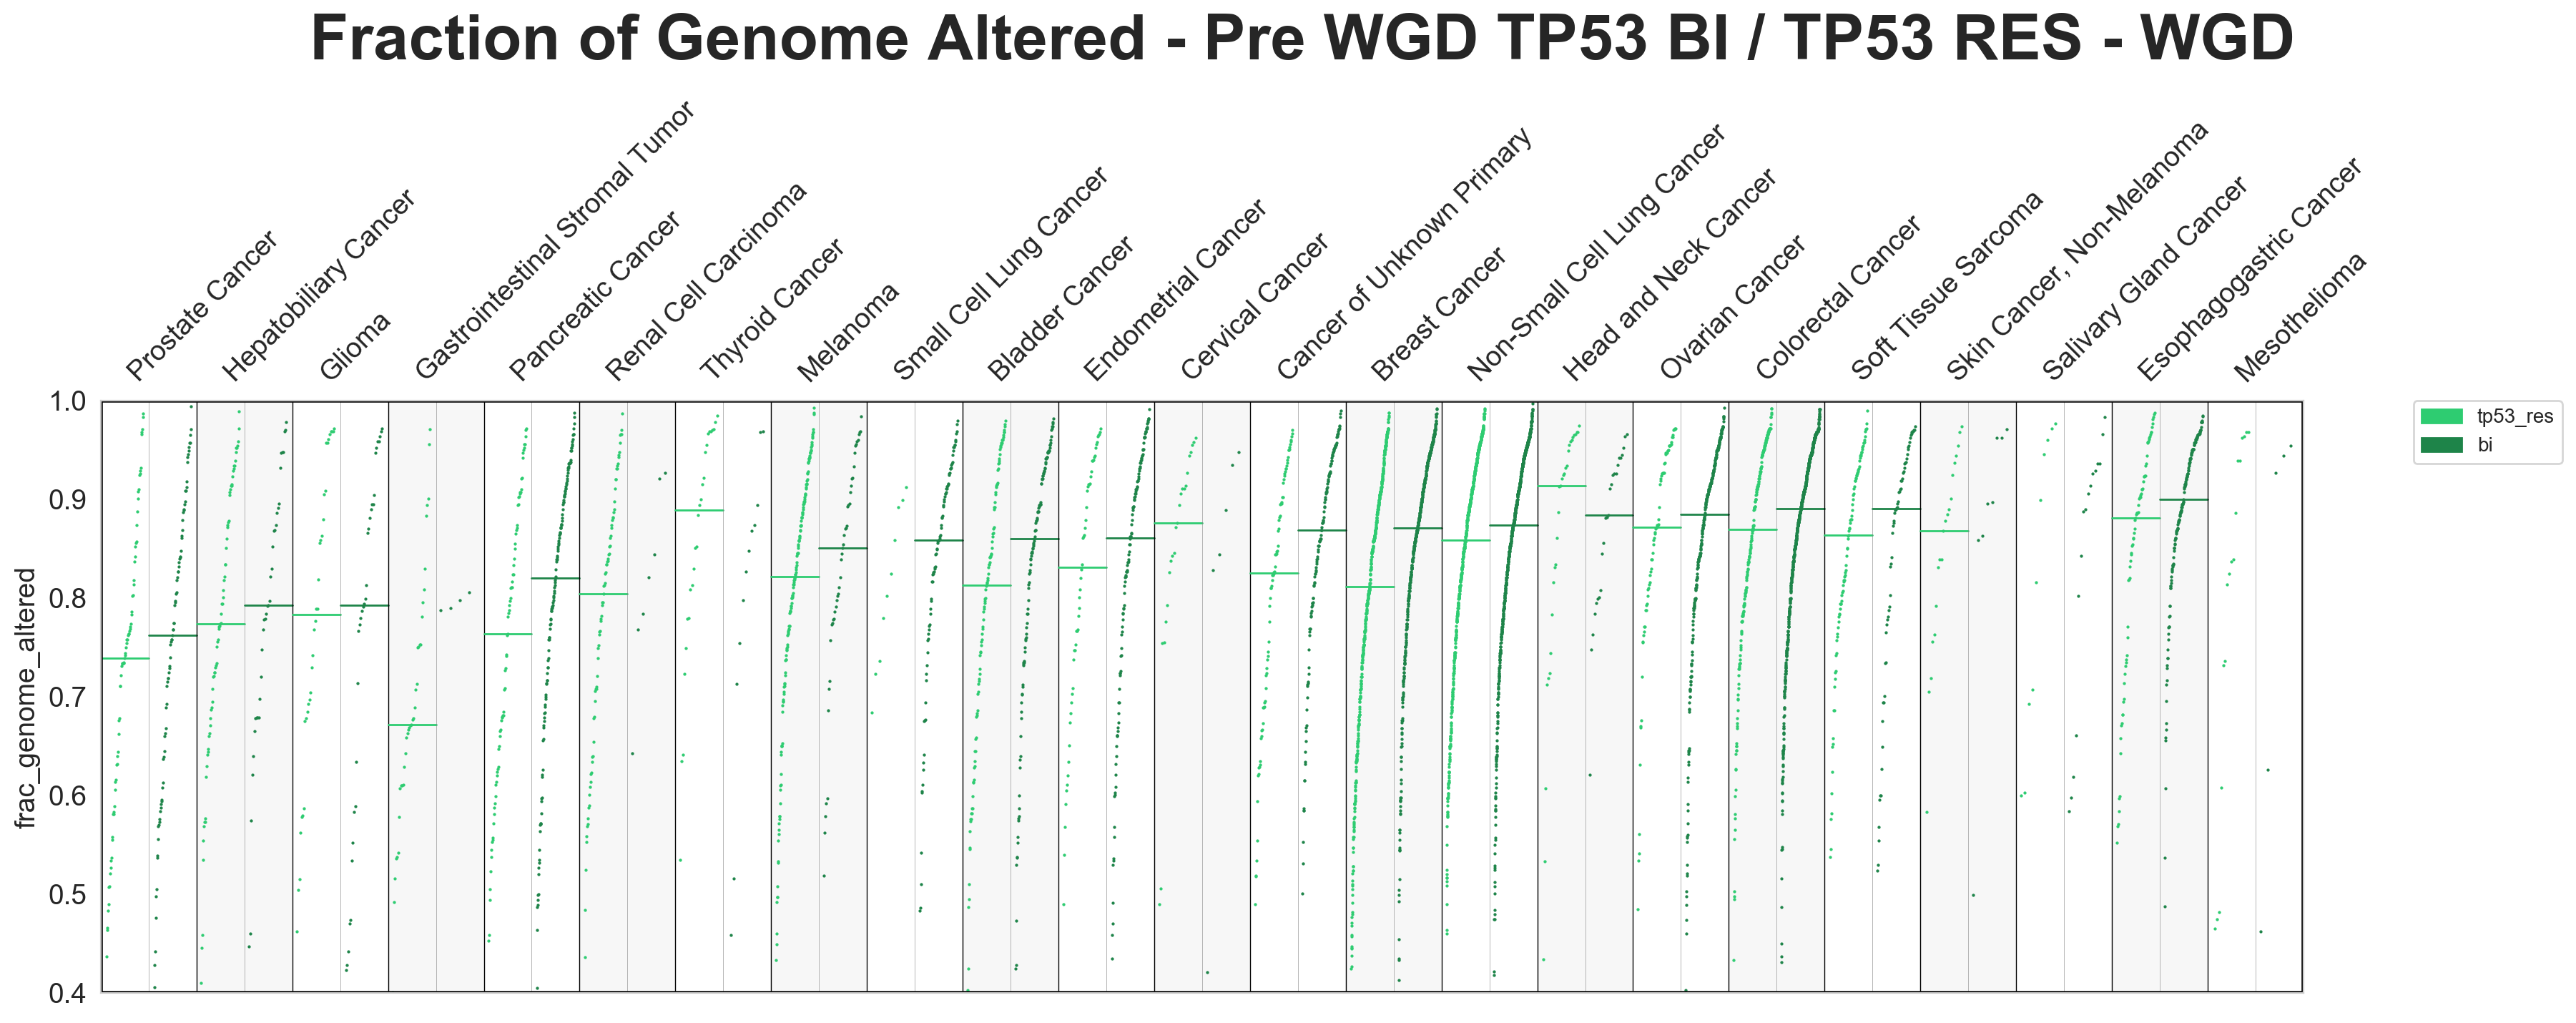

In [185]:
%%time
# Let's begin with. one subgroup : >=1_cnLOH
sns.set_style("whitegrid", {'grid.color': '1.'})

fig = plt.figure(figsize=(20,9))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)

import itertools
col = itertools.cycle(["#FFFFFF","#FFFFFF","#F7F7F7","#F7F7F7"])
labels = []

#order = medians.sort_values(ascending=False)
for i, (group, df) in enumerate(master_ordered.groupby(by="Cancer_Type", sort=False)):
    i = 2*i
    labels.append(group)
    
    # Non LOH Subgroup in Blue
    df_mono = df[df['prewgd_tp53_group_1'] == 'tp53_res']
    totalsamples_mono = df_mono.shape[0]
    df_mono = df_mono.sort_values(metrics)
    plt.axvspan(xmin=i-0.5,xmax=i+0.5,color=next(col),zorder=1)
    if totalsamples_mono>0:
        for j,(_,row) in enumerate(df_mono.iterrows()):
            plt.scatter(i-0.4+(j/totalsamples_mono)*0.8,row[metrics],color=palette_bi['tp53_res'],s=0.3,zorder=2)
        
        if df_mono.shape[0]>20:
            median_mono  = df_mono[metrics].median()
            plt.plot([i-0.5,i+0.5],[median_mono,median_mono],color=palette_bi['tp53_res'], linewidth=1)
    
    plt.plot([i+0.5,i+0.5],[0,1],color='#7F7F7F', linewidth=0.2)
    
    # LOH Subgroup in Orange
    k = i+1
    df_muts = df[df['prewgd_tp53_group_1'] == 'bi']
    totalsamples_muts = df_muts.shape[0]
    df_muts = df_muts.sort_values(metrics)
    plt.axvspan(xmin=k-0.5,xmax=k+0.5,color=next(col),zorder=1)
    if totalsamples_muts>0:
        for j,(_,row) in enumerate(df_muts.iterrows()):
            plt.scatter(k-0.4+(j/totalsamples_muts)*0.8,row[metrics],color=palette_bi['bi'],s=0.3,zorder=2)
    
        if df_muts.shape[0]>20:
            median_muts  = df_muts[metrics].median()
            plt.plot([k-0.5,k+0.5],[median_muts,median_muts],color=palette_bi['bi'], linewidth=1)
    
    plt.plot([k+0.5,k+0.5],[0,1],color='black', linewidth=0.5)


  
num_dis = len(master_wgd_cancers["Cancer_Type"].unique())*2
real_labels = ['']*num_dis
for i,label in enumerate(labels):
    real_labels[2*i] = label
    

ax.xaxis.tick_top()
plt.xticks([k for k in range(num_dis)], real_labels, rotation=45, ha="left", fontsize=14)
ax.xaxis.set_ticks_position('none')
plt.xlim(-0.5,num_dis-0.5)
plt.ylim(0.4,1)

# Border lines
plt.plot([-0.5,num_dis-0.5],[0.4,0.4],color="black", linewidth=2, linestyle='-')
plt.plot([-0.5,num_dis-0.5],[1,1],color="black", linewidth=2, linestyle='-')
plt.plot([-0.5,-0.5],[0,1],color="black", linewidth=2, linestyle='-')
plt.plot([num_dis-0.5,num_dis-0.5],[0,1],color="black", linewidth=2, linestyle='-')

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
plt.xlabel("")
plt.ylabel(metrics, fontsize=14)

palette_ = dict(zip(bi_list, bi_palette_list))
# Create legend handles manually
handles = [matplotlib.patches.Patch(color=palette_[x], label=x) for x in palette_.keys()]
# Create legend
ax.legend(handles=handles,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

fig.suptitle('Fraction of Genome Altered - Pre WGD TP53 BI / TP53 RES' + ' - WGD', fontsize=32,fontweight='bold', y=.9)
fig.subplots_adjust(left=0.08, bottom=0.14, right=0.85, top=0.6, wspace=2, hspace=1.5)
fig.savefig('./gi_pancancer/wgd/pancancer_frac_bi_wgd.pdf' , format='pdf')

### Pre WGD TP53 Allelic State Detailed

In [171]:
# First we order by ascending BI-Allelic frac_genome_altered Median
# Filter and order the samples in order to plot with decreasing medians on the cnloh subgroup
master_cancers_loh = master_wgd_cancers[master_wgd_cancers['prewgd_tp53_group_2'] == 'bi']
cancer_order = master_cancers_loh.groupby('Cancer_Type')['frac_genome_altered']\
                                .apply(np.median)\
                                .sort_values(ascending=True)\
                                .index\
                                .tolist()
samples_list_ordered=[]
for cancer in cancer_order:
    samples_list_ordered = samples_list_ordered + master_wgd_cancers[master_wgd_cancers['Cancer_Type'] == cancer].index.tolist()
#samples_list_ordered

master_ordered = master_wgd_cancers.reindex(samples_list_ordered)

CPU times: user 52.1 s, sys: 5.75 s, total: 57.8 s
Wall time: 21.9 s


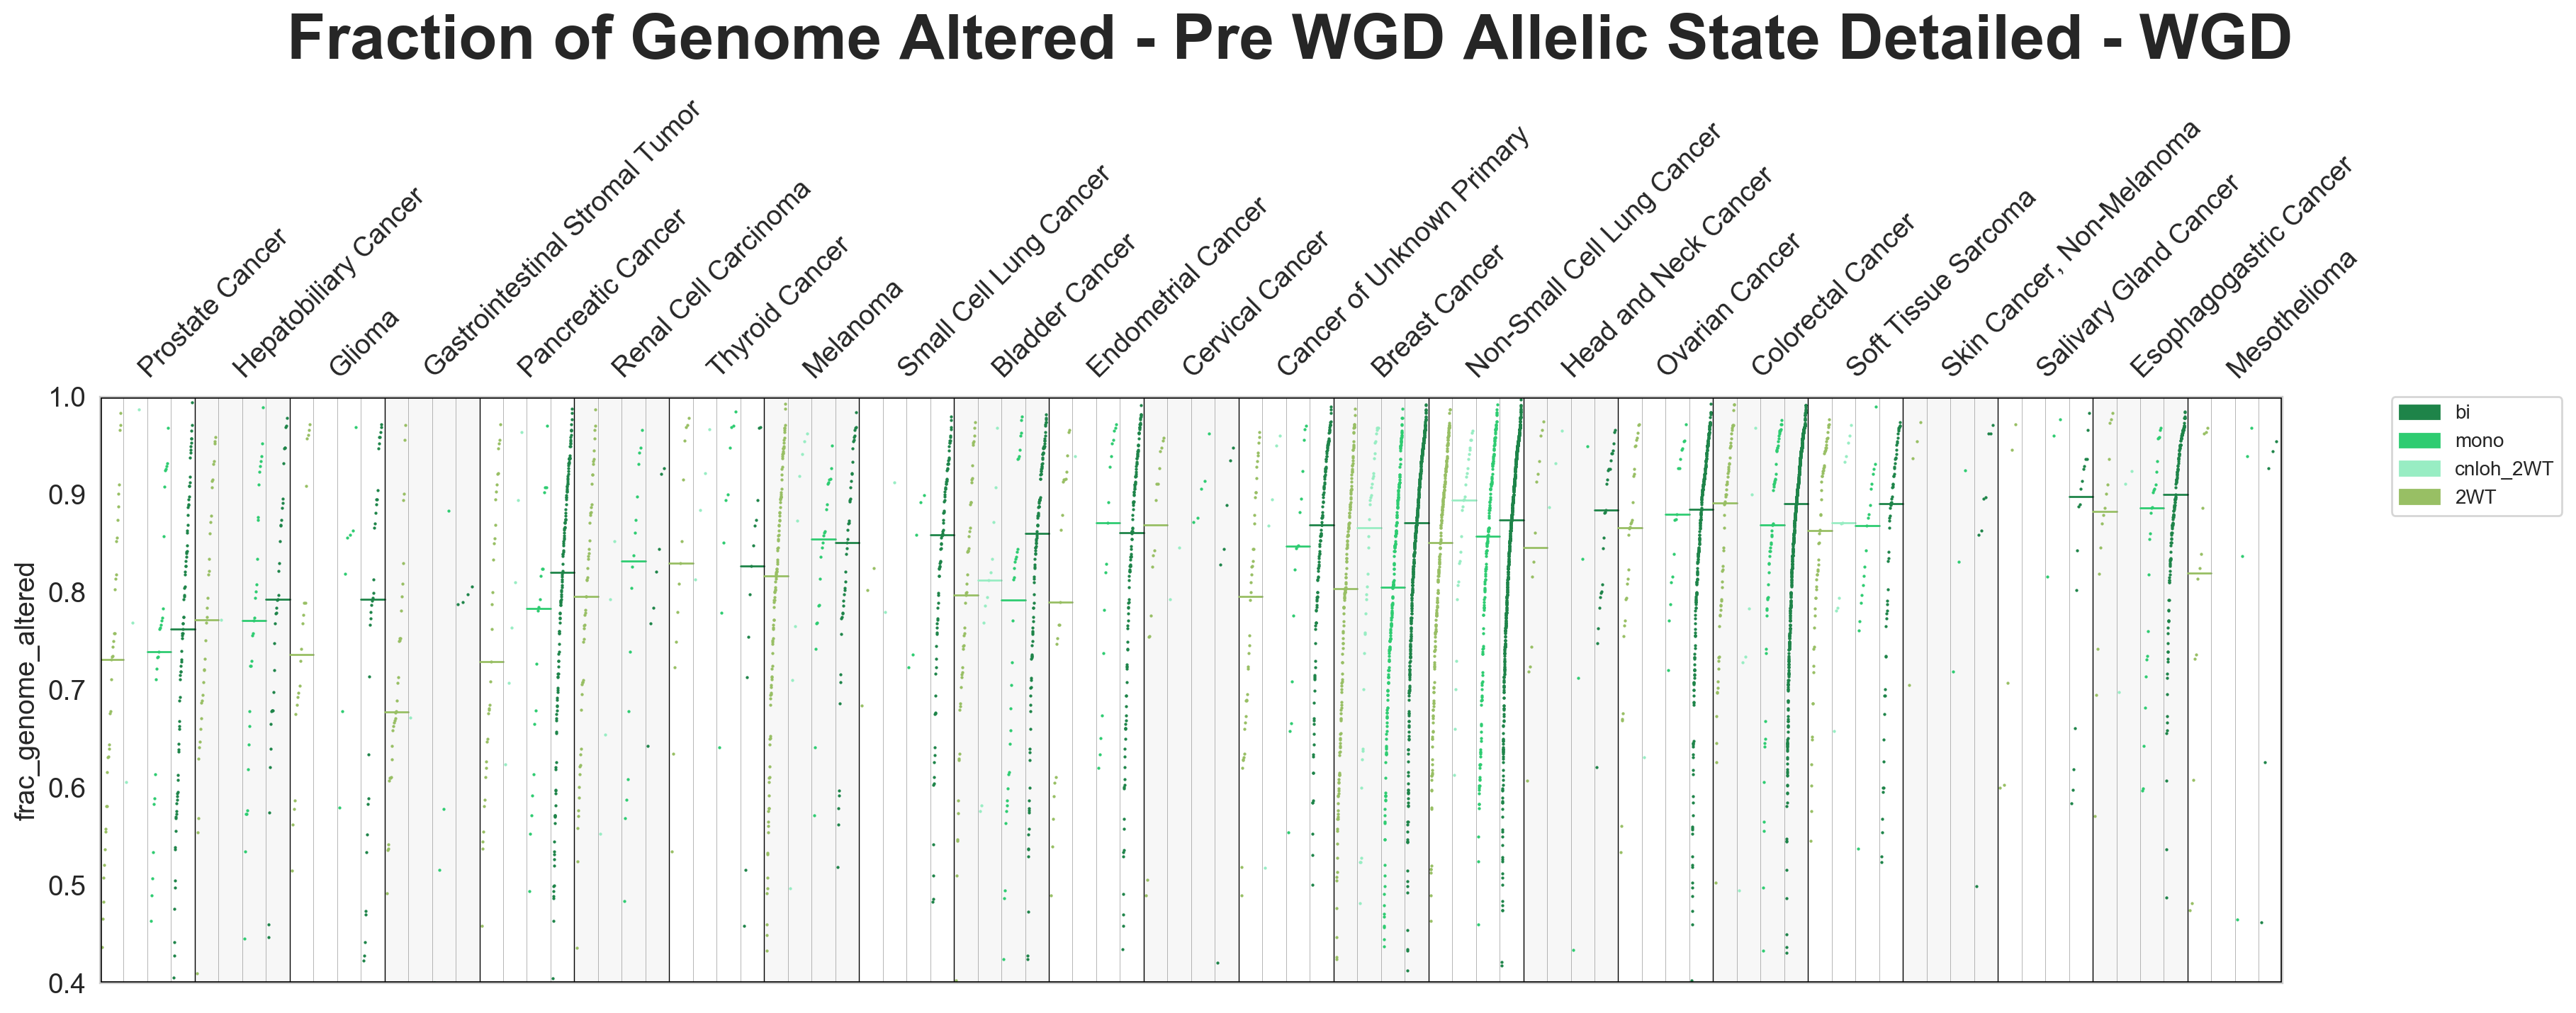

In [184]:
%%time
# Let's begin with. one subgroup : >=1_cnLOH
sns.set_style("whitegrid", {'grid.color': '1.'})

fig = plt.figure(figsize=(20,9))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)


import itertools
col = itertools.cycle(["#FFFFFF","#FFFFFF","#FFFFFF","#FFFFFF","#F7F7F7","#F7F7F7","#F7F7F7","#F7F7F7"])
labels = []

#order = medians.sort_values(ascending=False)
for i, (group, df) in enumerate(master_ordered.groupby(by="Cancer_Type", sort=False)):
    i = 4*i
    labels.append(group)
    
    # Mono Allelic Subgroup in GREEN
    df_mono = df[df['prewgd_tp53_group_2'] == '2WT' ]
    totalsamples_mono = df_mono.shape[0]
    df_mono = df_mono.sort_values(metrics)
    plt.axvspan(xmin=i-0.5,xmax=i+0.5,color=next(col),zorder=1)
    if totalsamples_mono>0:
        for j,(_,row) in enumerate(df_mono.iterrows()):
            plt.scatter(i-0.4+(j/totalsamples_mono)*0.8,row[metrics],color=palette_state['2WT'],s=0.3,zorder=2)
        
        if df_mono.shape[0]>10:
            median_mono  = df_mono[metrics].median()
            plt.plot([i-0.5,i+0.5],[median_mono,median_mono],color=palette_state['2WT'], linewidth=1)
    
    plt.plot([i+0.5,i+0.5],[0,ylim],color='#7F7F7F', linewidth=0.2)
    
    # >1muts Subgroup in RED
    k = i+1
    df_muts = df[df['prewgd_tp53_group_2'] == 'cnloh_2WT']
    totalsamples_muts = df_muts.shape[0]
    df_muts = df_muts.sort_values(metrics)
    plt.axvspan(xmin=k-0.5,xmax=k+0.5,color=next(col),zorder=1)
    if totalsamples_muts>0:
        for j,(_,row) in enumerate(df_muts.iterrows()):
            plt.scatter(k-0.4+(j/totalsamples_muts)*0.8,row[metrics],color=palette_state['cnloh_2WT'],s=0.3,zorder=2)
    
        if df_muts.shape[0]>10:
            median_muts  = df_muts[metrics].median()
            plt.plot([k-0.5,k+0.5],[median_muts,median_muts],color=palette_state['cnloh_2WT'], linewidth=1)
    
    plt.plot([k+0.5,k+0.5],[0,ylim],color='#7F7F7F', linewidth=0.2)
    
    # LOSS Subgroup in BLUE
    h = i+2
    df_loss = df[df['prewgd_tp53_group_2']=='mono']
    totalsamples_loss = df_loss.shape[0]
    df_loss = df_loss.sort_values(metrics)
    plt.axvspan(xmin=h-0.5,xmax=h+0.5,color=next(col),zorder=1)
    if totalsamples_loss>0:
        for j,(_,row) in enumerate(df_loss.iterrows()):
            plt.scatter(h-0.4+(j/totalsamples_loss)*0.8,row[metrics],color=palette_state['mono'],s=0.3,zorder=2)
        
        if df_loss.shape[0]>10:
            median_loss  = df_loss[metrics].median()
            plt.plot([h-0.5,h+0.5],[median_loss,median_loss],color=palette_state['mono'], linewidth=1)
    
    plt.plot([h+0.5,h+0.5],[0,ylim],color='#7F7F7F', linewidth=0.2)
    
    # CNLOH Subgroup in PURPLE
    g = i+3
    df_cnloh = df[df['prewgd_tp53_group_2'] == 'bi']
    totalsamples_cnloh = df_cnloh.shape[0]
    df_cnloh = df_cnloh.sort_values(metrics)
    plt.axvspan(xmin=g-0.5,xmax=g+0.5,color=next(col),zorder=1)
    if totalsamples_cnloh>0:
        for j,(_,row) in enumerate(df_cnloh.iterrows()):
            plt.scatter(g-0.4+(j/totalsamples_cnloh)*0.8,row[metrics],color=palette_state['bi'],s=0.3,zorder=2)

        if df_cnloh.shape[0]>10:    
            median_cnloh  = df_cnloh[metrics].median()
            plt.plot([g-0.5,g+0.5],[median_cnloh,median_cnloh],color=palette_state['bi'], linewidth=1)
    
    plt.plot([g+0.5,g+0.5],[0,ylim],color='black', linewidth=0.5) ##7F7F7F
  
num_dis = len(master_wgd_cancers["Cancer_Type"].unique())*4
real_labels = ['']*num_dis
for i,label in enumerate(labels):
    real_labels[4*i + 1] = label
    

ax.xaxis.tick_top()
plt.xticks([k for k in range(num_dis)], real_labels, rotation=45, ha="left", fontsize=14)
ax.xaxis.set_ticks_position('none')
plt.xlim(-0.5,num_dis-0.5)
plt.ylim(0.4,1)

# Grid
'''plt.plot([-0.5,num_dis+0.5],[0.2,0.2],color="black", linewidth=0.5, linestyle=':')
plt.plot([-0.5,num_dis+0.5],[0.4,0.4],color="black", linewidth=0.5, linestyle=':')
plt.plot([-0.5,num_dis+0.5],[0.6,0.6],color="black", linewidth=0.5, linestyle=':')
plt.plot([-0.5,num_dis+0.5],[0.8,0.8],color="black", linewidth=0.5, linestyle=':')
'''

# Border lines
plt.plot([-0.5,num_dis-0.5],[0.4,0.4],color="black", linewidth=2, linestyle='-')
plt.plot([-0.5,num_dis-0.5],[1,1],color="black", linewidth=2, linestyle='-')
plt.plot([-0.5,-0.5],[0,1],color="black", linewidth=2, linestyle='-')
plt.plot([num_dis-0.5,num_dis-0.5],[0,1],color="black", linewidth=2, linestyle='-')

ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
plt.xlabel("")
plt.ylabel(metrics, fontsize=14)

palette_ = dict(zip(state_list, state_palette_list))
# Create legend handles manually
handles = [matplotlib.patches.Patch(color=palette_[x], label=x) for x in palette_.keys()]
# Create legend
ax.legend(handles=handles,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

fig.suptitle('Fraction of Genome Altered - Pre WGD Allelic State Detailed' + ' - WGD', fontsize=32,fontweight='bold', y=0.9)
fig.subplots_adjust(left=0.08, bottom=0.14, right=0.85, top=0.6, wspace=2, hspace=1)
fig.savefig('./gi_pancancer/wgd/pancancer_frac_prewgd_state_wgd.pdf' , format='pdf')

# - 76 samples with T125T Synonymous mutation

In [89]:
onco = pd.read_csv('syn_TP53_T125T_180508.txt', sep='\t')
samples_onco = onco.Tumor_Sample_Barcode.tolist()
onco

Hugo_Symbol  Chromosome  Start_Position  End_Position     Consequence  \
0         TP53          17         7579312       7579312  synonymous_SNV   
1         TP53          17         7579312       7579312  synonymous_SNV   
2         TP53          17         7579312       7579312  synonymous_SNV   
3         TP53          17         7579312       7579312  synonymous_SNV   
4         TP53          17         7579312       7579312  synonymous_SNV   
5         TP53          17         7579312       7579312  synonymous_SNV   
6         TP53          17         7579312       7579312  synonymous_SNV   
7         TP53          17         7579312       7579312  synonymous_SNV   
8         TP53          17         7579312       7579312  synonymous_SNV   
9         TP53          17         7579312       7579312  synonymous_SNV   
10        TP53          17         7579312       7579312  synonymous_SNV   
11        TP53          17         7579312       7579312  synonymous_SNV   
12        TP53          17         7579312       7579312  synonymous_SNV   
13        TP53          17         7579312       7579312  synonymous_SNV   
14        TP53          17         7579312       7579312  synonymous_SNV   
15        TP53          17         7579312       7579312  synonymous_SNV   
16        TP53          17         7579312       7579312  synonymous_SNV   
17        TP53          17         7579312       7579312  synonymous_SNV   
18        TP53          17         7579312       7579312  synonymous_SNV   
19        TP53          17         7579312       7579312  synonymous_SNV   
20        TP53          17         7579312       7579312  synonymous_SNV   
21        TP53          17         7579312       7579312  synonymous_SNV   
22        TP53          17         7579312       7579312  synonymous_SNV   
23        TP53          17         7579312       7579312  synonymous_SNV   
24        TP53          17         7579312       7579312  synonymous_SNV   
25        TP53          17         7579312       7579312  synonymous_SNV   
26        TP53          17         7579312       7579312  synonymous_SNV   
27        TP53          17         7579312       7579312  synonymous_SNV   
28        TP53          17         7579312       7579312  synonymous_SNV   
29        TP53          17         7579312       7579312  synonymous_SNV   
30        TP53          17         7579312       7579312  synonymous_SNV   
31        TP53          17         7579312       7579312  synonymous_SNV   
32        TP53          17         7579312       7579312  synonymous_SNV   
33        TP53          17         7579312       7579312  synonymous_SNV   
34        TP53          17         7579312       7579312  synonymous_SNV   
35        TP53          17         7579312       7579312  synonymous_SNV   
36        TP53          17         7579312       7579312  synonymous_SNV   
37        TP53          17         7579312       7579312  synonymous_SNV   
38        TP53          17         7579312       7579312  synonymous_SNV   
39        TP53          17         7579312       7579312  synonymous_SNV   
40        TP53          17         7579312       7579312  synonymous_SNV   
41        TP53          17         7579312       7579312  synonymous_SNV   
42        TP53          17         7579312       7579312  synonymous_SNV   
43        TP53          17         7579312       7579312  synonymous_SNV   
44        TP53          17         7579312       7579312  synonymous_SNV   
45        TP53          17         7579312       7579312  synonymous_SNV   
46        TP53          17         7579312       7579312  synonymous_SNV   
47        TP53          17         7579312       7579312  synonymous_SNV   
48        TP53          17         7579312       7579312  synonymous_SNV   
49        TP53          17         7579312       7579312  synonymous_SNV   
50        TP53          17         7579312       7579312  synonymous_SNV   
51        TP53          17         7579312       75

In [63]:
samples_in_wgd = []
samples_in_no_wgd = []
samples_not_in_cohort = []

for sample in samples_onco:
    if sample in master_wgd.Tumor_Id.tolist():
        samples_in_wgd.append(sample)
    elif sample in master.Tumor_Id.tolist():
        samples_in_no_wgd.append(sample)
    else: samples_not_in_cohort.append(sample)

In [100]:
#WGD samples
print(len(samples_in_wgd))
get_groupby(master_wgd[master_wgd['Tumor_Id'].isin(samples_in_wgd)], 'prewgd_tp53_group_2', 'WGD')

15


WGD
prewgd_tp53_group_2     
2WT                    1
bi                     2
mono                   9

In [99]:
get_groupby(master_wgd[master_wgd['Tumor_Id'].isin(samples_in_wgd)][master_wgd['prewgd_tp53_group_1'] == 'tp53_res'],'tp53_loh_status', 'count')

count
tp53_loh_status       
False                4
True                 9

In [98]:
get_groupby(master_wgd[master_wgd['Tumor_Id'].isin(samples_in_wgd)][master_wgd['prewgd_tp53_group_1'] == 'tp53_res'][master_wgd['tp53_loh_status'] == True],'tp53_cn_state', 'count')


count
tp53_cn_state       
LOSS BEFORE        9

In [93]:
# No WGD samples
get_groupby(master[master['Tumor_Id'].isin(samples_in_no_wgd)], 'tp53_group', 'NO WGD').sort_values(by='NO WGD', ascending=False)

NO WGD
tp53_group         
0_HETLOSS        12
1_WILD_TYPE       5
>1muts            2
>=1_LOSS          2

In [77]:
# Samples not in cohort
annotated_cohort = pd.read_csv(data_path + 'impact-facets-tp53/new_data_facets/msk_impact_facets_annotated.cohort.txt', sep='\t')

In [80]:
get_groupby(annotated_cohort[annotated_cohort['tumor_sample'].isin(samples_not_in_cohort)], 'facets_qc', 'count')

count
facets_qc       
False         22
True          14

In [88]:
annotated_cohort[annotated_cohort['tumor_sample'].isin(samples_not_in_cohort)][annotated_cohort['facets_qc'] == False][['wgd', 'purity']]

wgd    purity
136     True  0.242836
3611    True  0.327177
5130   False  0.592344
6440   False       NaN
9811    True  0.320072
14635   True  0.371428
14964  False       NaN
17929   True  0.878379
18187   True  0.321034
18892  False  0.300000
19589  False  0.183227
20236  False  0.300000
22196   True  0.208844
22311  False  0.207885
25423  False       NaN
27361   True  0.658126
29005   True  0.579195
30275  False       NaN
30634  False  0.794469
30964  False       NaN
30982   True  0.451574
36764  False       NaN